## Multi-label prediction with Banknotes

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
#For CPU only 
fastai.torch_core.defaults.device = 'cpu'
defaults.device= 'cpu'

## Multiclassification

In [4]:
path = Path('.') #'/home/jupyter/.fastai/data/banknotes/')
path_imgs=path/'imgs'
path_imgs.mkdir(parents=True, exist_ok=True)
path_imgs

PosixPath('imgs')

In [16]:
src = (ImageList.from_folder(path_imgs,recurse=True)
               .split_by_rand_pct(valid_pct=.2))

src

ItemLists;

Train: ImageList (679 items)
Image (3, 500, 359),Image (3, 201, 500),Image (3, 225, 500),Image (3, 219, 500),Image (3, 281, 500)
Path: imgs;

Valid: ImageList (169 items)
Image (3, 215, 500),Image (3, 375, 500),Image (3, 640, 480),Image (3, 262, 500),Image (3, 480, 640)
Path: imgs;

Test: None

In [22]:
src.train.items[0]

PosixPath('imgs/usd/50/IMG_20190730_232610.jpg')

In [7]:
#single class
func=lambda i: str(i.parent.relative_to(path_imgs) )
#multi class
func=lambda i: (i.parent.relative_to(path_imgs).parts )
func(src.train.items[0])

('euro', '5')

In [8]:
ll = src.label_from_func(func); ll
#ll = src.label_from_folder(); ll

LabelLists;

Train: LabelList (211 items)
x: ImageList
Image (3, 428, 500),Image (3, 255, 500),Image (3, 255, 500),Image (3, 500, 305),Image (3, 500, 435)
y: MultiCategoryList
euro;5,euro;5,euro;5,euro;5,euro;5
Path: /home/jupyter/.fastai/data/banknotes/imgs;

Valid: LabelList (52 items)
x: ImageList
Image (3, 278, 500),Image (3, 267, 500),Image (3, 217, 500),Image (3, 400, 500),Image (3, 333, 500)
y: MultiCategoryList
euro;200,euro;200,usd;100,usd;5,usd;10
Path: /home/jupyter/.fastai/data/banknotes/imgs;

Test: None

In [9]:
tfms = get_transforms(do_flip=True,flip_vert=True, 
                      max_rotate=90, 
                      max_zoom=1.5, 
                      max_lighting=0.5, 
                      max_warp=0.5)

In [10]:
#so its reproducible
#np.random.seed(42)

In [11]:
def get_data(size,bs):
    size=int(size)
    bs=int(bs)
    data = (ll.transform(tfms, size=size)
        .databunch(bs=bs) #for CPU only add ,num_workers=0
        .normalize(imagenet_stats))
    return data
size,bs=256/2,20
data=get_data(size,bs)

In [12]:
data.classes

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']

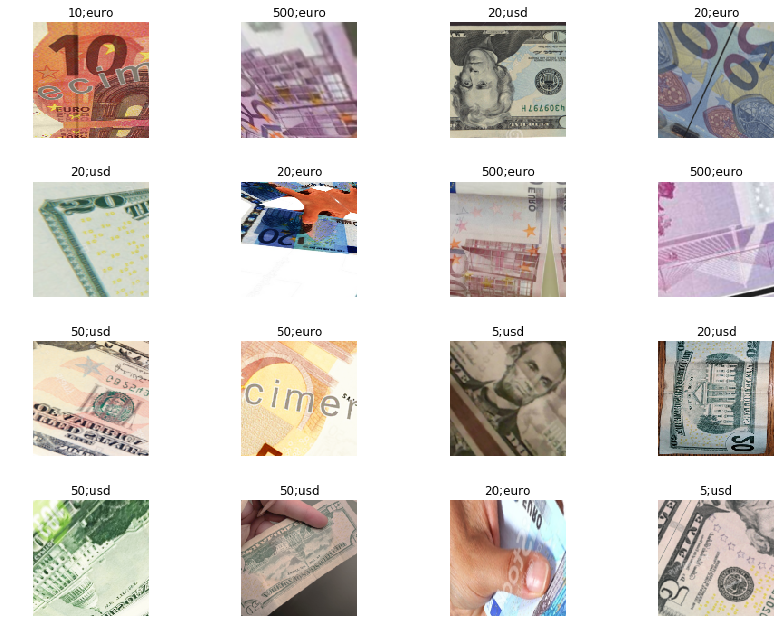

In [13]:
data.show_batch(rows=4, figsize=(12,9))

In [14]:
arch = models.resnet50

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
#multiclass
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
#single class
#learn = cnn_learner(data, arch, metrics=[accuracy])

We use the LR Finder to pick a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


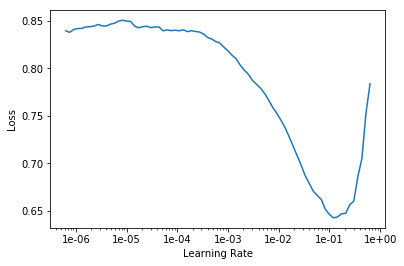

In [16]:
learn.lr_find()
learn.recorder.plot()

Then we can fit the head of our network.

In [17]:
lr = 1e-2

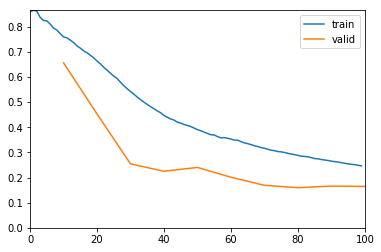

In [18]:
learn.fit_one_cycle(10, slice(lr),callbacks=ShowGraph(learn))

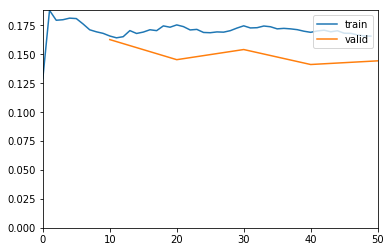

In [19]:
learn.fit_one_cycle(5, slice(lr),callbacks=ShowGraph(learn))

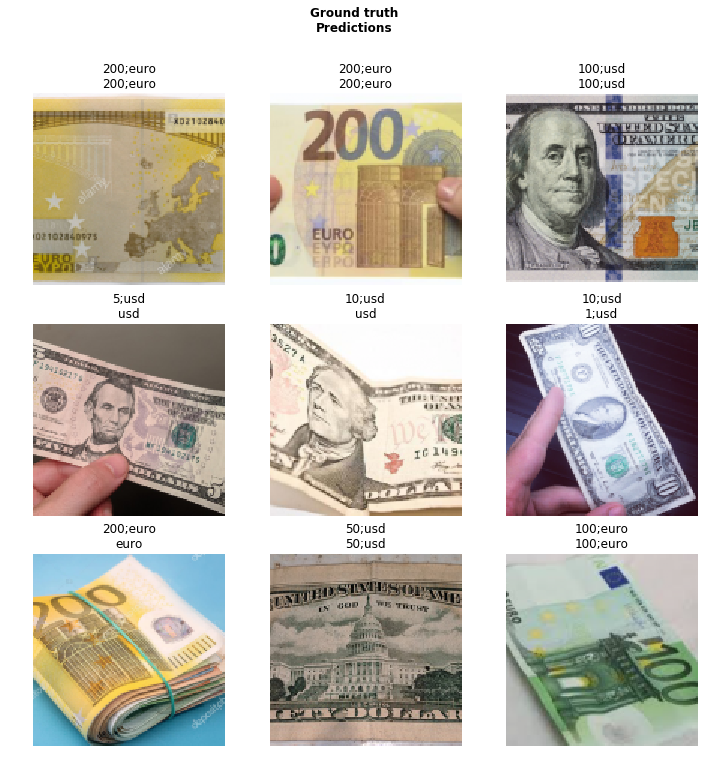

In [20]:
learn.show_results(rows=3)

In [21]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


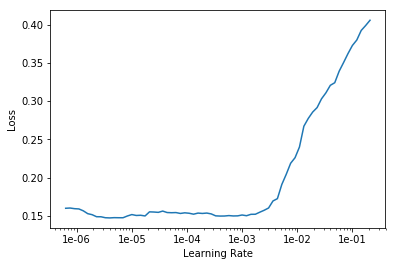

In [23]:
learn.lr_find()
learn.recorder.plot()

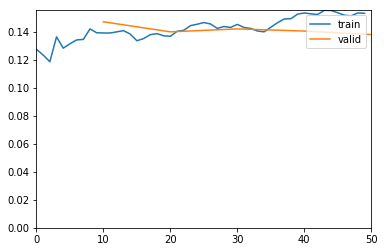

In [24]:
lr=1e-4
learn.fit_one_cycle(5, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

In [51]:
learn.save('stage-2-rn50')

In [45]:
learn.load('stage-2-rn50');

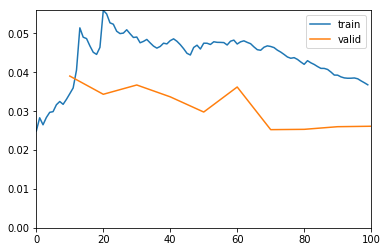

In [55]:
learn.fit_one_cycle(10, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

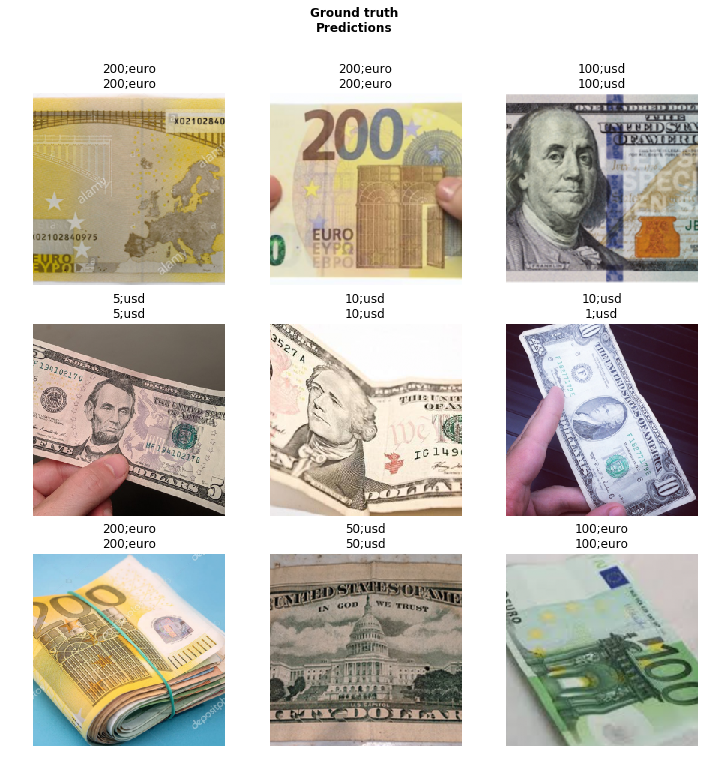

In [57]:
learn.show_results(rows=3)

In [62]:
learn.save('stage-3-rn50')

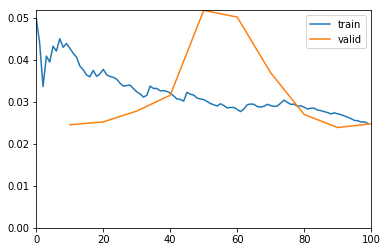

In [59]:
learn.fit_one_cycle(10, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

In [60]:
gc.collect()
torch.cuda.empty_cache()

In [61]:
size,bs=256,10/4
data=get_data(size,bs)

In [63]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


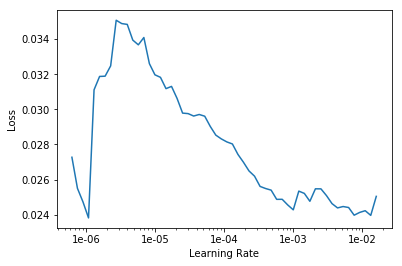

In [64]:
learn.lr_find()
learn.recorder.plot()


In [65]:
lr=1e-4

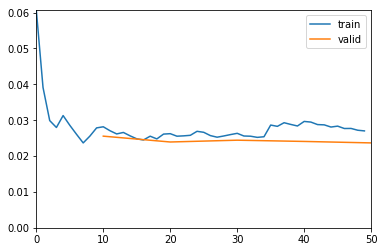

In [66]:
learn.fit_one_cycle(5, slice(lr),callbacks=ShowGraph(learn))

In [69]:
learn.save('stage-1-256-rn50')

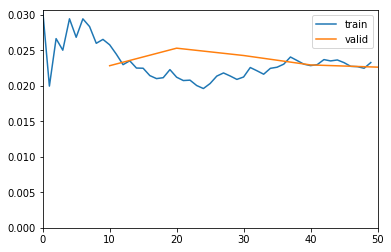

In [70]:
learn.fit_one_cycle(5, slice(lr),callbacks=ShowGraph(learn))

In [71]:
learn.save('stage-1-256-rn50')

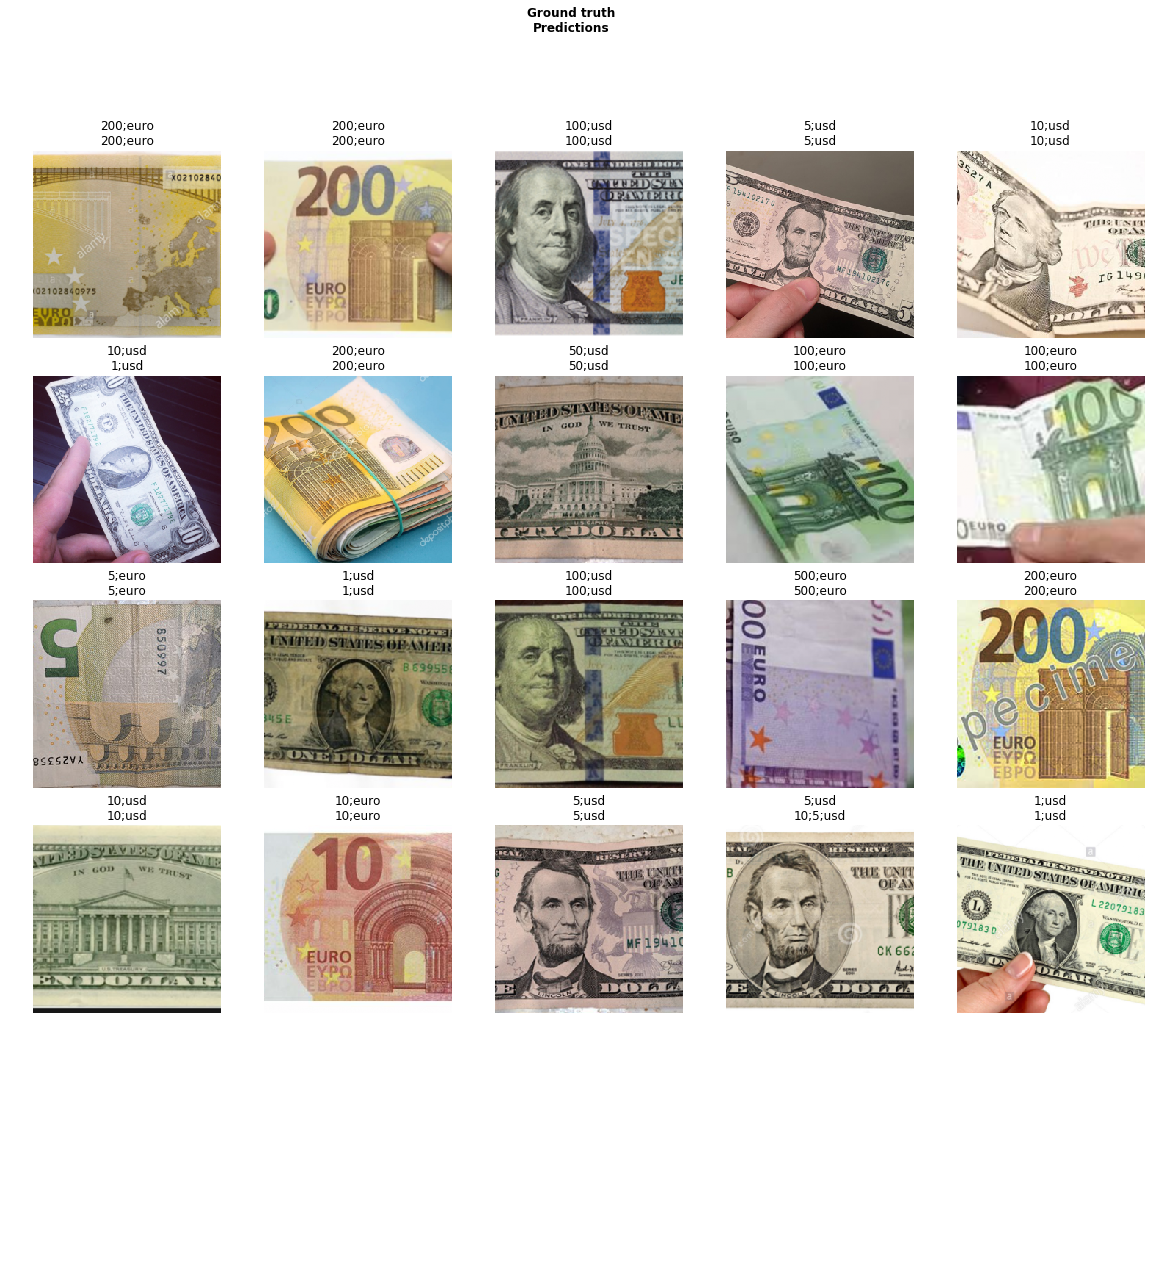

In [72]:
learn.show_results()

In [73]:
learn.unfreeze()

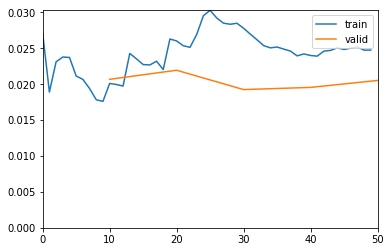

In [75]:
learn.fit_one_cycle(5, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

In [94]:
learn.save('stage-2-256-rn50-fbeta9930')

In [92]:
learn.load('stage-2-256-rn50');

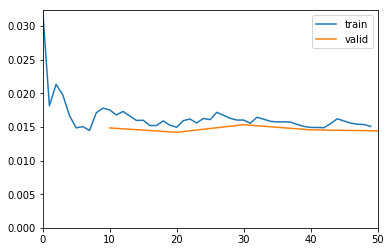

In [95]:
learn.fit_one_cycle(5, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

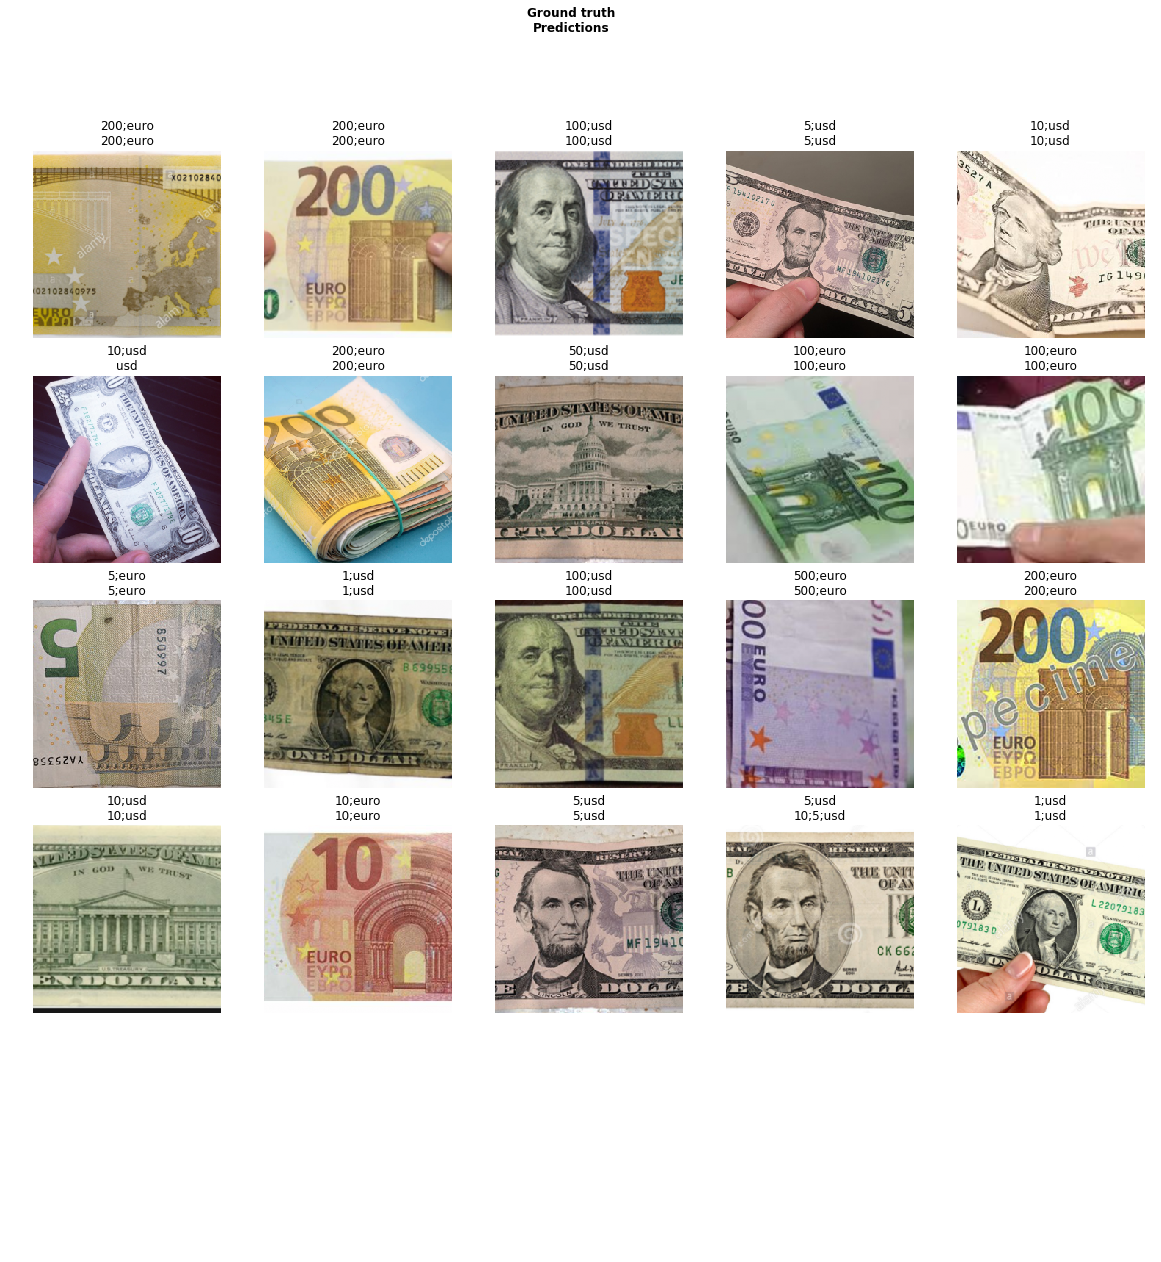

In [96]:
learn.show_results()

In [97]:
learn.save('multi-class')

# Inference example

In [57]:
imgPath=src.train.items[0]
img = open_image(imgPath)
pred=learn.predict(img)
probabilities=[ '%.2f' % float(100*elem) for elem in pred[2] ]
dict(zip(classes,probabilities))

{'1': '0.26',
 '10': '0.03',
 '100': '0.00',
 '20': '0.01',
 '200': '0.00',
 '5': '0.03',
 '50': '99.99',
 '500': '0.00',
 'euro': '0.00',
 'usd': '100.00'}

In [64]:
a=[b'1', b'10', b'100', b'20', b'200', b'5', b'50', b'500', b'euro', b'usd']
[c.decode("utf-8") for c in a]

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']

In [98]:
learn.export(file='multi-class.pkl')

# Convert to PyTorch model in TorchScript format 

In [5]:
path_img = Path('models/')
model_file = 'multi-class.pkl'
learn = load_learner( path_img , model_file )

/Users/brunosan/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
model_file_jit = 'multi-class_jit.pth'
classes_file='classes.txt'
classes = ['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']

#trace_input = torch.ones(1,3,299,299).cuda()
trace_input = torch.ones(1,3,500,500)
jit_model = torch.jit.trace(learn.model.float(), trace_input)
output_path = str(path_img/f'{model_file_jit}')
torch.jit.save(jit_model, output_path)
# export classes text file
save_texts(path_img/'classes.txt', classes)
tar_file=path_img/'model.tar.gz'

# create a tarfile with the exported model and classes text file
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'{model_file_jit}', arcname=model_file_jit)
    f.add(path_img/f'{classes_file}', arcname=classes_file)

## Upload to the S3 bucket

In [11]:
import boto3
s3 = boto3.resource('s3')
bucket = 'iris-ai'
s3.meta.client.upload_file(tar_file.as_posix(), bucket, 'fastai-models/iris/model.tar.gz')


# Test inference

In [7]:
#model
path_img = Path('models/')
model_file_jit = 'multi-class_jit.pth'
classes = ['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
file =str(path_img/f'{model_file_jit}')
model = torch.jit.load(file, map_location=torch.device('cpu')).eval()


In [112]:
from torchvision import transforms
import base64
import mimetypes

dataURI = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAASABIAAD/4QCMRXhpZgAATU0AKgAAAAgABQESAAMAAAABAAYAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAABIAAAAAQAAAEgAAAABAAOgAQADAAAAAQABAACgAgAEAAAAAQAAAUGgAwAEAAAAAQAAAWYAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/AABEIAWYBQQMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/3QAEABX/2gAMAwEAAhEDEQA/APWmvpui7Afpmq73N0QczMPZcCqYvAwO23un9MQkfzpDfuASbWQf78iL/wCzV5Lc31PRskSh5XfLTSH6saJRz94kH17VnTavDFy0llH/ANdL1BWbceLdOhOJNW0lP+3guf0pckmO6N4KMe3rTgAeP1rkW8c6MMqusRSH0t7V3pg8Y2rj9ymsz+8NgRn8xS9lLsHMjs1xnHYVLgVxI8SXcwzD4e8RS+hbbGD+tImtaxcbhB4VvXIOD5uoqMfXB4qvZMXMdsyj8KjLKpyxA+pxXC3er65a7DceG9OthI21Tdan1PpUzJ4vdN8OjeHkPYNKzH88U/ZeaDmOx+12+cNPCMDu4/xoN9Znj7TCcf7YryBPG/i19eXSI7HTILppPLwtvuA9856V266b43ePP9v6XG2OiWP+Jq5UWrXaEpX2Ol+32n/PdD9MmgX1uejOR/sxMf6V5ND4t8RR6w+l6t4jksJvM8tWSwV1Oe5PGOa7JfDniKZQz+Nr3B/5520a0nR5d2HNfodL9tUnCxXJ+kBFO+0uelpcH3Kgf1rxvxFrU+n3Ulha+Idfu7pW2li6omfQBeTWfourvc6jBY6vc6xK00oTel8ybc9OK0VDS5PtNT3Lz5cn/Q5P+BOo/rUsVzcBxi1X8Z1FcnJ4F0U2zuTqErBCR5l7Icn86q+H/B+j3liZtV0Z7SRWIH+lycrng/e4qFGPcq7PR1uZBEDJaTKPVSHH6HNKk8Uo+SQE916H8jXnWt2OieHbeK707W9QtVLbSlrfByvvtbOR7Vs+X4ps7ZZvNsdetNu4eavkT49iPlP6Vo4JrRk3OrECSMQ6g0LZwqSPKTH+7XK2fjOxjfZfNdaTLj/V30RZD/uuOCPxratvENjcLmDU9KlB9Ljbn881n7NlcxpNaxqCAMD2OKER0yA7/ixquL+R/uRwSD/pncqf6U5LubnNjKf9x1b+tHLqK5b3SAf6xqUSygffJ/AVVa7II3Wt0P8Atnn+Rppv4h1WVfZom/wp+8+otC158277ykduKcLiXphfyqh/aFt/z0x35Uj+lKL+16mdB9Tip5prqOyL/wBpkH8Cmka7kAP7pT+NU/t1qx4uYv8AvsUouYDkefGc/wC2Krnn3CyLIv3Of3I496Uahj70OB67qp+bH/z0Q5/2hSiQY+8OPen7SfcVkaC3gP8AyyI/Gl+1oDjy2qmHGAQaXJz04p+0mHKi0b6Nf4Go+3xKfuPVQ/SmHryOaTqzDkiXDqUY6RP+lJ/aajH7pifqKpHjk/ypM4HNHtZhyRL39qdcQH/vqlGqN2gx/wACrO3KW5wMUu9CfvgfjS9rU7hyRNP7e3/PIfnR9vb/AJ5D86p5i/vD86Mxf3h+dX7SfcXLE//Q1NR8KWdrpck/2nVL2UAbY5r9wGJPTgisuTTvDen27rqOgOt6IfMCK8lyv4nNXb/U9Z1ixa1/4Q/UBDJjO+dIzinQN4kh082UPhe0ghKbCZ9RyxHuetefFStq/wATvbXQTwVp+ha5pDXc/h/TkdZGTKwdQD1wa0LKG1i8U3VlDp9mlvHGrALAvBPviqFo/ibTLRYLeDw5YQg52tdM5Gepqv52riaSZ/E+hW8sn3jBbl2P4k0STbeoJmr4vjis7e3ubNxa3pnRVMPylxnoQOtdDISdMlZy2fKOcHnpXANZvNcCefxpNLMOjR2O4r9ODirbWwcAS+K/EEg9Eg2/+y0vZq1rhzDdGS9mt0Ph9r2FvMPnyX+XQ/QZwfwqTwpZ6nbeKdXku8yIxA80JsVmyc4FQtptjgB9U8Uy/wDbXaP6VC+i6Ix/eRa/If8Abvcf+zVVlqv0Fc6bxRbm6is2Nmt0kc4LpuxgZ+974q5dhp7Ei21L7I235XQocH8a4k6H4bC86FfS+8l//wDZULpPh5RhPC8J/wCut4T+nNCgv6/4cfMyppelLpUV/qOoajbT6pKSkYN2iMFzyd3IBNdhpnizS4dNhGoazYxThRuU3SyEH6jr+Vc+lnpa/wCr8K6Qp/2iW/8AZasiNAoEfh3Rhjn/AI9mP9Kc4qW/6EptbGf4vPhLxBNBew69p8V3G6l28z7y59u9dLH478LQwqv9uW7YGMKCf5CqEf2wr+70fSV9CLEn+tSCTVu1nYqf9nTz/wDFUNJqz6D1uc/peoeDbLV59VuNSN3du5ZNsDkRj2GOvvWTPc6Rf+LTqxnuzbrLvWOKydi+ORz2rt/M14jAWJf92xA/macV8RsoAuZU/wB23jH86alZ3/r8hWvoRjx5ZyJ5cWja1KpG3ItD0/OoPD/iBtIia3TQtfnhLl1LWvKZPTryKuLaa8339RvPpujX+lSJp+teYCNQv/f9+v8AhS9xaD1MnxldaTr9nAZoLzSZkbiW5sXAIz3K5rutI1bSr3TFh0/Ura68uLbhJBngenWqQt9ehhyLy4kX+7KqSg/hgH9awr3TbG7k36loNuZe09kxt5R74P8AjVuzVidblnQ9RaGBbez06/1GJmfzoZQD5Jz/AA7sDHtT/CXhvQr21nubvR4zdNM4dbiP7uD0A6flVewOo2R2aX4pCxr0ttaiyR9H4z+tWrSHxBBZvbG20XUA0jSB0vDGQSc8ccfnRZ9GF+5b1TwLptw4ay0/S4UH3laFwT9GRhj8qxNc8O6doGgy3w06586Ij/j2v5sY+ucirdkniXT7kTPo+pSRAn9zHqqSxn8GGf1p+r63rF3aPZP4T1WKGcFZHRo2YD2GcULm7hdEmj+HbTVNJt7+z1rXbZJkDBfthbHtyKptb3trq09ifEviCJYhuM7QpJFj3bHFT6d4kXRrCGyj8Ma8kMKhFJgDfyNUH8RrJql3NcDxBFZzpsNp/Z7FR6nPOD9KfvXC6H6pfaho89pHL42mdLo4jk+xRyL7Zwf1rbbTvFiRb08SWcq4z+8sBz+RritVh8JX32AWkVxpy20gaR3sJSzqDnHT+ddsnjrwz5QT+0ggAx88Tj+lJrS6X4Bcoadc+JtWt2nstV0a4VWKNvs3Uhh1HWiWTxclwIZIfD5c8qCrjcPan6B4n0kQz2t1rOnhxIxjeMiMMp6enNc944kuGvbLVtF1qG5W2+ZojeJhcdcDIzmhJ3tYL6XN2VfFiRFm0nw+yqMlvNYYH5VRg1rW7iwkvItO8PyW8ZIaRbo4XHXtW5pfijStU0iGeW9tUaVP3kTyqCPUEZrzrxEsZaXw94bZXhaQz3LeaoUsx4GSegpJXdmgb0udtHdeJ5IlkTQNHkRhkFbw8j8qZFquvTTPBHoOlSTJw0aaj8yn6YrV0iW2sdHtLZ7+2Z4Y1RiJV6gfWsEwC71DVIobWztGkYeVqazKXbnrjOaSs+gynq3jK/0K9gtNQ8N20Mk2Cp+2kr+JxxWla6trd9GJrXw3YzxHo8ephhXFfEPTZl1DTY/7Rm1GeSMINxXrnHGPWtrwPpGteHtEv5ykUVxIytFbSyD5gOvfjNXKEeXmITd7G3c6l4itkLzeGLOOPuz3/A+tV7jV9ctzEr+HdO8yX/VRi+LM/wBABXR2Gs2+o2pW4VYJtuJbeZhlc/zFczealpmieN7MSyxpA9p5UchYEIc9M9s1mtehb9S8ZvEUVo91daRolpEi7nMtwzbR74FOhfxHdWqXFjbeH5UkAZCC/wAw+pFXtblh1Xw3e29pcwSSSxEKFlU5P51W8M3Ntonhqwtb++tYZoogHV5lGD6daNLXsPqR+d46/wCgFo/5n/4qjzvHX/QC0f8AM/8AxVa//Cb+HP8AoOWP/f8AP+FH/Cb+HP8AoOWP/f8AP+Facq7Bc//R2l8LCVQJLpiD/eldv5mpE8IWgUKzoQPWPJ/U1XHjXS4LlbRxOtwX8tYzEwJb06Vo3uqXFjAJ20+ZkYgfJ8xBPqK8tuoegrMgbwxp6nJZSRxxCo/pVpNEsolA+fOOzAfyFY2t+LxoDJ9ssJj5gypQAj889asN4ha60Matp8KzjbymcH3HfkUWm1dg7G1FpVmBgq5+rmpBp1ih5hUk9Msa5vV9f1DRtGGoPHC0uBvg3YK598VT0nxZqOq6Feas8MUK24YKm4ksRjvinyya5hXR2n2K0CcW0Z+ooFla9reLH+6K87vfGPiC18O2uqvDbp9pciOI7unY5z3pt14s8Qp4d0/VozB5Vw+yVdpOw5xwc+lWqcmLmR6IYraPIEEf4IKkEcYXIjUHHZQK818Y+IdZ0H7NJb3SyJOpO2SPJH45Favmate+FrO8tr901CeISBSimMnHTHalyO17hzI7MOMZwAe9OVsk84A5zmuC8JXmo32k3zavNKJ4pTH8ihSh+lc54c1vWdR8Yx6fdX8kloS427VXIAOOgpqk3fXYOfY9jV92ACCfY1H5hJOR0JFedeM9RvNDWLUdJvJY/Ll8uW3kO5T6H1/Wt7w34lXWtLgv3Uqsj7JF67H9Pp6UcjtzdA5tbHSzHYu7IA7moftEL5BmVWPTmuK+JPiC90qO2tbOQxNPnMg6ge1Q2XirQY9HtYBc2TS7AJlu2O7d35/rUxhK3MNySdjujPGFbMw6fjSR6jAhJ89R7nNcXolnbRy6xfWd0k1pNa/KqXHmCJucjrmuf1LRV07wF9pustdzyhhuPKLzhRVqmr7kuWh7lDeQS2/yTIxxnGadJ5Ui7XCsuO4zXjfhPSZdQ+H2oy2ks0F5BN5kciOQxG0HGR29q6rWtevND8D2V7H+9uHij+/k5YjnOKpws7IXNpc6/wDsWzmZvl2Z7KePyNUX8LWfmkgRkn1gWodP8SRt4Vj1uTLI0AlcD8iAPrVWD4g6S2npqMy3EVszFFkeM4yOv86EpBdFl/CsSgiORUI/ull/kaj/AOEbuQR5d5IvuLmQf1pD440VlSb7TtjmXMbOCoYDg4yPWrU3inS7NU+3XK2xbp5p2hvcZobl2DQrf2Nq0ZzHqNzx0P2on+Yp4sddTBGoXJ+sqH+a1dj8Q6bLaC5S4Q25P+tDDb+fSrNpqdlfI32W5jkC9Sjg4/KlzPqBkvD4hBOLyY8fxLGf6Uzy9e7sknrutkP8jWy2oWkb+W1wu/8Au55oTULQuQLhM5wVzyKOa4GC8GpEHzLCyk7YexH9DUDWTsjGXQtJk9jZkV1gZy5JIKk8EHtTnbZzkAU+ZhY4SXR7JkKyeF9JZupOxl/pVY6NpLH5vCmnZHpIwH8q9B8+Nvl3KfbNRyuqknI2465o52gsjzttI0cn5/CNoD3Czn/CkfRdEUZHhS2H/bweP0r0HzEZeCOR60hkQL2Gep4o9o0LlRww0jQdqt/wi1vn2uDSf2RoLYJ8NRdP+fkmu43lIwyqG56D0pWcbgAgx36Uc7HY4NNJ0AcjwxASf705NI+k6KG+XwpZt7mY/wCFd4MAHIFIzHICBaOdhZHDLYaWh/d+FtOU9/mY/wDstSraWuT5XhrSsj1jJ5/75rt9wAySBjuaYsybsiRc/Wjm1CxyX9mp/wBC7o//AH6P+FH9mp/0Luj/APfo/wCFdl9sj9/++qPtkfv/AN9VXMFj/9Lm70CX4n28a/MRcqSMdMf/AKq9B8mW71mcmVvKRlGzfx1/+tXGT6RqFn8RYtQksJpLJptxmjjLBR746YrvrO18u8uLhMNA537ipHA+orz5tNK3Y7orcztY0231W01GC4KghsoxP3SOhrzzwxqdxoOtTaTdI5guX8sr12vngj2rvFGqz6jfFdKlXT5Y/wB3IxUMWznOM5waq6v4Umv7/SdWsQgljdPODNtBAP8AOqhK3uy2FJN6op+Pin9l3ZVsfMg4/GofBqw/8IJKssj4e4IO3qBx0rY8S6Hd69BcWlnJbI3mAu0smMYHYAUzRfD9/ovhuXT7mSzkIcyK8UmSc+xFCa5LBb3rmN8Q5DcaVZxW8DrFG+FXbg4wK0PDpibwJZRTxko5IYbenJ5Ge9S+IPD9/wCI4LVI9Ss7OKLkbi241bstJm03w/Hp8uoWdwYDuV0YhiM9CCafMuSwrPmucl8TWMosfLidI0Uj5x05re0i0uzYeH7kXzeQkQ32zRgDG085HXHvTvEPhgeJWgluNdhs1RMCMR8n3OTVu40hZdAg0ka9bQpFGIzOqZdl/FuM07rkSBLVsfZ363zXxs1Bt1uAHkKjLHjnjt2rz3wplPiNGxyQJJF4Psa73w/pOmeGdOubWLW0nE0gfc6fdP0B56Vm2HhLRtM1ldXj8Qu1yrlsNENmTnsKIuKugabszP8AH8hOl3YwBvuFA3Dnoal8DWsll4Ju5p1IW4l3x5PUDjP6Vsahpehapcxz6rqLXSRncsEMRRWJ6lsZJ/Or8SHXLiOGCDyNOt8AKOAQO3FJSXJyhy+9cpeIbfTdWbTdN1QtHJNHugnUgMHGOPTn+lc7J8ONPkkaOLWGE+cKskQxn3rt/EPhay10273L3KC2OUNu+1l9+lUimmqF3aldPInAleIb/wA8cn3IpKdl7rG43ep594Ksbqz8ai0QqyAOs6qcjA9R9cV0vjoyXXh4zs6bFmWPAHTGRWrYx6ZpQmj0S0ke7nPzzyncz+/+cVPfaDp8lnH/AGxbT3KjBKRysFB9wCOfeqc05KQlGysVfhsGh8H6j5bK2ZcjHUHAGK6W+hi1PwzNYtBw0flqQuVUgdQfrVfR7fQNLhmWwS7s0nHzBW3Ln1AOeafZ2o0zTzbabrL3CLIXVJwBIMnJGeMjPtTbTdxJWVjk/Aatq3hXV/DssirPbMdhfsjH+hBqX4i2Vpp/hPTtOtCoS2k2bvU45qS103xJpHi6XWF0eN9Pnf8AfiJlZ9rdeB7845pfHmnz3ulxJpen3d0rTGTEcDjYMY5yOuarRzTRP2RmlaHb6x8L7WBwftEcjNAx7NuPH0NQ/FiIx6XpQf765GPwFaXhtJIfAqWdxbzW9zDIxaGVCpxnrg9qxPiK0VzZ6bHbrLdOGLSKisdnAHPp0ppvn+YP4TZ8N6paweC9BsZZTuuz5Pk+WSHyTkE4xirGn+HZ/DMXiIaYyMs0YkgXqyEA8Y747Unh2+tLH4eWL3mxYoAXkSQ4dcMSMDrnPSs7QPEtz4ibxDfzZhjtoQ9shH+q4bB+vrSavcfY5fwb4qj8PX19NqEUk8lwvM4G90YE9QT0rfvNZ0bxasKPcxJqEbgwyyxGEtz90npzWjpR8NeKtMF/caXbXF0PluAg2OrepAPIPrXLeOdC0zTJ7BtHjlRrsENaZLN1wCO/NV7rl2ZOqR6xBdsmsC0Xb5WwHAP3TivPPF3inUNS8WpoVlcPBbrKsUjRHDNk88+ldtpMc1kmmRXGPtZtVVyw5BA7+9ea+JNJk0fxyt5IwWGW5WaOQ9D8wyPqKmCV9Rts9H1TyLa1lsIoCriAlJlbDKwGQc/hXJ+DfFV1rks2k375uEXdHIOPMAOCDjv711GtlxdSMdoUwE5zx901wHwy0yafxA2obMwWytlscZPAFCinFtg3qQWGrao/j6DTHvrk2ou2jMbN1UZ4Jro/Gdpq1tA97pF7PFHA+2aAvuGP73Tj6VxtvH9q+J4VmZVN63AbaR16GvRoLSDS7DVLOOWSUvP5v71yz84ByT1pzVmmJapm5bXyQQ28MxLGSEOCe5x0rzzV/FOoaV4/jW7Z49MLAGPsVP8AH/Wuum82a9sjKI8MgWJFYAtxkjH0zWF8QtDm1XR3vlSPzbTnYrAkR9x+BqIWvqU9tDrbu7idvs8rOBIoaORT1H+NeWz69rPh7xhFFqN7NLZiT7jkYMZ6HgdR1rpfB1/JrugLp0rA39jt25YZKdj/AJ9Kq/ELS49S0K11W3Cl7cYcg5ymcH8jVQSi+Vik76o3fHV5dweFJLmzuXjZWQo8ZwcE1k/D29muNHvtQv5pbuaObYvmuSAMDp2HWotUFxb/AAkhW9m3TsI257Ln5R+WKb4CY/8ACLaiseMfaRk/gKLLkfqF7yO0/tu3/wCga/8A38NH9t2//QNf/v4axfMl/ufpR5kv9z9KXKWf/9Pt7uynlPm2l29tKRhiOQ34f1qj/Y9/cMBf35liHVVzz/Kt7OO/amyEBa8lNrQ9ExLnQjLIDDdyQxgD5MkgfTmrFlpjWkLwyXBnicfcK9Kv87c0vTB71XN0AyE0C2USBnZt/QkDK/Sov+EYs88yy8dhgD+VbYAI5pOh5oTaFYzP7AtTAUaSZ1H3SWHH04pg8PWHTM3I/vD/AArYAyCRzSEHIx2ppgzMOiWTQiF/NYKcgl+R7D2qL/hH9PLDKSkd8vWxtyeORSFTv70OTEZR8PaaQf3L8/8ATQ1I2h6czHdbZ4x94itErmnY4p8zaHYzE0XToiCtqhI6biSP1q6qpGgSJVVR0CjAFSsuRUbZPIHNK9wsByDgniqkljaTM0kltEzH+IjrVw4Yc0wrxwDTAiht4oFxHEkeeoUYp+0E4OCD1zTbm4itkzKwA7Dua5291u4kkMNpEeeA6sp/rz+FCuSdstrY/ZsTx2wH+0AKoTafo75xKkfptl/xrGtNO1W7tcsWVTyTIip+oOaeNI8rKT6pbRKeqtdZH5NmteUk1k0+4OGsdSBYDBy2M/lUf2TX0cj7YCfQt/iKzF0W+JU2s8MqgcGKb/8AWKSKw1qCVj+93Y7yA/yAp20C5oTQ+IZI2jkeJ0IwQSppbddZgtNkaIroMbWIbd9PSs7+1tVs2ZJlLEdmdf68/rVy28SIxIuIRGR1Icf40tbAKZ9eJJayjc+pjB/rTZLrWvKdP7Mi+YYJEf8A9ety2uoLtMwyBu+PSpckEg/ypXCxzSNcRwxNJosJwMZSLB/TpRE6x3QmttCRLkjHmMhLY+proyetIW4xTuFjK0+wuWumvb0/vSMKnpT9U0uK+t2D20N1GeZIJRw3uPQ1fzyPQ96ehycVNwscmbfTUtDY3Z1JogNoiLbcKf4MjnH41bs4t9sLHTdO+yWQ4bYdh/P1rpl2HqAfqKHXC5XniqbFY8zn8LeGbS8km26lFqCsXE/nHcr/AN6tWxawWZY5Z5plePZJJPjJb1JrrZYYnfMkSMfUqDUYtoP+eMXH+wKHJvcaSOZ1LRNMtrq3v7lr+SWI5gkSY7Y8+g6Cq0R0y6muIZWl8q4XDbm2Fs9V3D1rsGVSux1Vh6EZoSKID/Upkf7IpJiscPDo3hrSLoyWthfWk4UoxSYgkHqOtSAaNDphsbWC6WA5Aikk3Lg/eHJ712+yN2JKKT7gU0xR9diAD/ZFNyu9QscpdR2GsxyRXmmPcWUCqUjDkDA74HWoLA6LYLJFYaTJbCTllRjhj2JGea7HAAwFA47cU+JV3jgZpc3Qdjkft1x/00/77b/Gj7dcf9NP++2/xruvLH9z9KPLH9z9KLsLI//U7m61EWv2n90G8mESZzjPXiqB1xy8AmigiVgDJuZ8jOcAZX274qHUL/RXAubuyM5UiMEgZwRnuQOh+tSuNJijWVNPQiJ/LUlRkAjJ615dtNT0BmneIY71oRIqQb2dSHbB4IxjPqDS6lf6hZ3F3skt/JihEigxndyccknFTQTRT28t3eabFF5I3oX2uSuMgg44ql/wkdrJFbTNaKReIVLEhgCGxtJ6HqaelxjH167iu7SPMU8MwjDSxqMKzEjnBIx+PWmPrl0tvMyXEDbWXcwUARZYjaSTjOOea1rS833jWv2SOKMbhGysDnacHK44rM/4SRxFPtsYlSOTYWO/aDkj5sL14zxmi1+gh8eqXr63FDFLvtCVBkEalDlcnkHOfTtXSZrA/wCEgeK2WeS1RIiil+TkbgdvboSP1pp1+Zrq8tY4YRNbwiQb2bDMB8w4HbimkB0PQ4x+NBwKybPUL6bUPss8UICxK7vGrkc9ACePzrX6g0gGEYzSDJPB471L/D1qHo+enajyGKGHIGTTec01W468nJxSh+lGwCnp61l6prUNgDGjIZ+ylgMf/XqvreuJaKbeCRfPbjlwuPpmsWJYNPtG1TWJmWFfuqSrGU+g4qlHqS2PjgvdWd57iTbABlnlCFAPrWHq3jKw0km30O3iurgAg3TphAf9kDr/ACrG1vxVfa8/koPsunjhLdOhH+161ikBUzgcdq6IU+sjKUuxpzatqerQB9Sv7iUn+APhR9AOP0pHt0MAdAGKj5gR29aXTtOu9VcW1nBJI5A4GOPrnoK9C0r4eRxQhtTutxI5hg4A+rGtJOMSUmzzizlkgO+GZ4wP7jEfyNa1prer28+Y9Uuh3GZSefzr0KPwJ4fkLoIJUx0ZJiDWZP8ADvSVmYx3V7CO3IcA/iKXtIt6j5Wc/D4816I4nmgu48dJ4gc/UjFbtl4t0XUU8u9tTYSnjzIsOmfoRmsjVPAGoW0RaxuobpNvRhsb6Y5B/OuRlS7tZjDPAYXQ8hgQaLRlsF2tz1xrO4jRLnT7g3FuRkPCy4H6cVZsvEYDCG92jsH3qT+nWvKdN1TUNLmE1hcyQN/EM5VvqDwa7XS/EVj4gP2W/SOxvz909I5vz6Gs3BofMegxukqB42DKe4ppA5rmI7u70e52TH5e4d88flzXQW1zFeQiWMg56juKzasUSHBOc9qkUfL157UzGO1CjFQMmUkH2p+81ETt6HFGaq4hZMMM4OajGOeKcTu4zTe9IYzaOopwGDn1FZt/rul6dN9nu7xIZNobawPQ/hVmyv7XULfzrWdJoycblOadmiFUg3ypq5Nkg5BpwYqPUdxVa/vrbTbNrm6kEcSdT6+w96o6d4jsdSn+zx+dFMRuCTRlCw9R60We4SqQjJRb1ZrMQQcA4p8ABkBBrF1DXE028jtPstzcSyIZAsCbuAcVNpWry312Y2028tQq7i8yAA+1JJ7i9tDm5L6/15HQfP6UfP6Umx/7v6UbH/u/pV2Ye2p9z//V6xvDlrJbrA9xcEK5cvldx4xjp0xx61ONHtluC4eYrkHyjJlM4x0+lX0YdR0pjHuOleVzM9GxWi0m0jtpLdFcJI258uWLe2T29qd/ZNgd2bZCC27HbOc8DoOR2q0rdx+tLmi7EV4NPtLW6luYoQJpfvyFiSfzPH4U77PCqqgiGwNvA7BvWpuu7+VMxkZFF2xkf2O1K4EEeOOMccHI/Kg2dqVGYUIBZunc9fzqXoPakzyeSOPWndiI2srU3CXPkJ5yDCvjkD0qdW9utMOcdc0dEHOaAJN2RUTuocA0qnr1+lN3HJB6UIGIpXAU9RWRrerJplvtDATOPlBNaFzIsMDTucBBmuJSSbWtXZ3by0HJZWddqDv0xVJJ6ibHWxhhtJdV1GZlt4+TiXO8/wB0DAridY1e68QX5uJ8JGvEMS8qi1a8S6v/AGzfCCHeNPtsrEufvHux9SaoQQhEDBe2Oa6owtqzKUr6CLEFT5cn0zVvTNIuNVvhDGAsYGWcrwo9fei2t3urqK3hG5nbCj09zXpGlabBpVmIUGcHLN/fPrROfKEVdmz4f0y20fTFgs4yC3LufvSH1Na8duX/ANadw9P89aq6YweEtn7o29elXR1wc/nWLdyyRIkiyVRRnvih41JIKj+VSoPkGMH61Xdm3cjOOmKSbApvbwLuXZjPWsDXtCiv7QeYomjXkHo6/Q10Lng5/Ooj93HYimnYTPI9Q0wafIVBLRMcAn7w9jWdOm8MRkDPcdMV6hrmnR3NuZVTLgYIA+8P8a88ubZ0maPeSAPlbGcrW8ZXRm1Y1fD3ix4tulay7S2h+WO5zh4T2ye4rq5DcaPeeYh3xNyCu5tw/WvMZ4Nu4DDAn8a6jwt4gQIuiao+YH4t5H58pvT6Upw0ugT7npdncx3lussfccqeoqUBsjBI7GuRtZptG1Ty3+4ThlCgA+/WuwUpIqyKQVIyCK52rGiYvOBin7uKapxnj86Q/dNCAMnJpDyaMjPNKeDSA4+/u7ez8Y3D3NtJcKbRAAkPmbeTyR2p3hZ47vVdVvLaLyLZmVBARhtwHLFe1Pvbi803xVc3kemXd3DJbJGGgXuCSetT6Fb3r6hf6rd2/wBk+0hFS3JywC929zWr2POgm61vN9Pxubc9pb3aRrcwpIEcOu8Zww71y9zc3N54v02O7s/sSwmRondtxm46Ajp64rf1KPUZIEOm3EUUqtuIlXcrj09qyotP1jUNWtbvVRawxWmTHHAxbexGMk9hUxtuzeveUlFJ7rpo/V+RJqlrqo12C906CCTFsYiZn2hSWznHU9Ks6Tqd3JqUmnajDHHdIgkVomJR1PGRnkVJqDayJFGmxWbx7fmM7sDn2xUOi6bfJqkup6nLE91IgiWOEHZGgOe/U0aW1FaUavu31evY6b8vzFH5fmKduH91vyNG4f3W/I0zo9kf/9ZbHxfqLajaWjRwxwq2243qRIFHGQM4Iz1Kmu0hu4LgZhmjkxydjg/yrysWkCalPFqcq210sYkiaSRiFGMjbkkgnnI/nVzw9rEHh9Lm4urOULOiynylG4r0D7f5+h+tcEop/Cd6l3PTt43Dn8KnB6EHJqnbSfareKYIyCRQ21+GGRnmrY+6MDFYDHA8HtR78UnQHNAIII9qEAEEgjP5U0420vpjtTSPY1QDhjrTM4H9KU8Y9qQAY9fejUTFAHPXGaaeaVsjjv3qG8nS3tmlbAAHr1NNLoDOe8R3jM62cYdl6udjEfmtczr90dJ0NbGH5bu+w0xUnKR9hyeM1rWccdzeS392MQQgyyMyDkDoMgmuJvri41TVLm8k481uFPYdh9MVtGGxnJlS3hbIXC8+oq7HHmI5piQYwCCSOtXIEEsiR5ChmGWPatmQjf8ACengB7x1+Y/KmewHU/n/ACrprmVTEFDANjAx296qafCkEBVBhI1wv+fzqCRzLc7QPkHqP1rB+87mq0R0+k4+xjg8DpWgHVucZAqhpwIt3GDgD0q1bAlsHPPWiwmzRiPJFQSv8xyRmp42CEYJH1PNU5wWmycfQ0gRBM2TkYB71AxHzc8VPJHycKGHT6/rVfdhjyRg9KYncaysUAzz2FcNrNqn2plReR8ygZ6HqB+PNdvMxC8KQPauT1m282eGRHKnzCpOeoxnH6VcdxSOWlgkJbKNjHX0qhPb4XIUZ9emK6Ge2bLFW7dCOtUJbfLEN6cEZ/nWqZDR0ei3/wDbukmKbH9o2SYJOMyxeuSDyK6bw5qAcGylcMy8rzk/yFeYWF3Jo+qRXtuSWjO4qf4l7j8q7eeQQXMN/aMzW8qrNERub5T179qznHUqLO4yADR2waht5xc28cqH74zUhP8AnNZbFiMfShWzjtimt83ToaRTjj1pWAcx4+lNHTkf/WpXxt/Cmnrx+NADgOOtJ29qUdDiuZ1DxPPp66kJbONprJkJjEh/eRNzvHHYA8exppX2E2dKHIPXinxHLcVjS6wtrZz3swRrOMKVeLLMQQCTj0Gc06fxFp9hex21xcRJI8fmgySrGGGcDBPWjlY7m9vb0o3t6Vz3/CYWn/PKf8l/xo/4TC0/55T/AJL/AI0WYrn/1+duru30RLmDVo7l72aQeZcvmRiF6YyeCP8APWm2lxJq1qdUeaJIY+CJSDJLJ02gAcAjt9K6n4h6Ot1pTXIUeYgycD06f1FcjolnLo+orDBJFGt1AtwlxON3loDlsDuSK41JSjd7na738j0XwvrV3qizRzWflxwbVScPkS5GRx24xXSdsV5/4W1K8t9SXT7W2+02Tu5aY5RkAPDEH1BHFd9kMOKxktbotDsnHFKpww55pvfpzSj16VNmA7I55puRimbe/v0oz3x1pDFJBI5+lNAwaCMHpTsdSDT2EKRyOa5zxPeBIVtQy5brkqP/AELj/wDXXRZwSTwBXHOzapr/AJRbAL8gOcY6njHp71cd7slszdblNjoVvp8QAmuz5s20AYQdBxXPxQYXLY49K0dZuf7R1y4lX7it5cfptHH86qiMldp6+1bQWhm9SKWIBPlAHoCcZptmoN1CHGdrbiMdMc1N8znaE3MemOSa1tJslhPmzsvmHIHfA9BVOVkJI6GJSLONfuhsZ+tUAG+1uByAxOPXFXnINuCCASeBnsKhhdDLtHHr9ayRZ02lPujfd1xyO1WEdom4IXPOSOgrP0hjh8fN7CrF9PcRjbDFuJIGT05poDOvbz7PcALNIZB82Qc4H0AqbT9XuLgPHKFlYt1UYx7kVFqlzqGlRIbGNAzOqO7x5Lknk+wAq0LO5mZZHCB9vLAYB46//Wp6EluYbApJ5JAqG4uorVHe4lVI0PLOamKmW1G9syKeSB6Vyups19r8kJuVht4VVpC65AJ9P896IobZuDVbSXasbs4bq2MKv1PrXP69CRGuDsAuBg9OxrRsptPZWFjepceXxInQ/gDVXXkT7DbFXIR5xt56dTinazJMeRAnQ8e4qrKoII9eTVuVxkeWMrjg/wCNRuPvYA49DVIRh3UK7WLDIOSBW54ZuBf6Lc6XIF8y1zPAMA/L/EvP51nzxBxhuR1JJqrp1/8A2RrlpdciNZMSgj+A8GqeqFsz0PwvdAo9pvB2crhgcfl/niuifJXgc1xpZtL1oFWLRq+M/MQVPIxxjp712G7jPb2rCS1NEEZPOe1L096YrYc0rEbue1SMGOR7Z70dfekLA9Tmk+vegCQEYrOutItrjVodSlG6WOB4NvZlY9/XHP5mtBSMYxVO/vY7WM/OA2O3b2+tUmJlKLQLOGwhskaT7LFG0YibDA7upOR1otNAghhjge4lnWKLyY/tCJJtXt1Xr71HY6nJdyMm1l2gEfPnuOOlbcRO7tjNF2hWTOU/4Vp4e/vXP/gQv+FH/CtPD3965/8AAhf8K7PYP7lGwf3KeoXR/9DpPE+BoN1nGMAc15sBayR6ELu3Z0+xuQGbbhB75znOT9K67x5qn2PRHjDfNIDj19B+przCNzr80cciyR2tlbEsUG4gAfpkgCuKlC6udk5WdjvtD1C4tvEfkWVkZLaeQqyrJuMaBVO4tXoqk7eRn3ry34eNd25tYorR5LeWJnllAwIyW+XP1A6CvUUB7moqK0rFJtky8joKacg4FIOFJzRnis0UGec4pCR2NJ/F0oIG7/GnYAJHFCngimk9cDHagHjP6U7CIL6cQWMznOcY4GTXL2Mxt7fUL0lsxwkrneOT04b+lbevvjTig53HgYz/AFFc1qKiHwqQw2tcThQoXHA/E+lVBEs5yJMoMjBPOcc1KzALn27DvSxJzz2zxQyhmwDyeCMZBrczNbSrVWUKV+YruY9PoKtrCtvO0wUcDBkY5/BRSaa6tHINgG1VBI/z7UmozssVxPtDCHKKB2OOT/Soe+pV9DJ1DWvLkZW6/cCocn2rT0iOdoDJONpHAQ9R7msPw9ai5uTdXKBnDFIsjID4yTj9BXWQoYrPMgBk2kbumTmnKy0QLU2NNkKZIJA6Edv5VrxlWUFVznGcmsLTWGX2+grTilZDgHg1NtBXJpi8YYxhi2P7ufpxSwC4htiZnZpGGev9O1TRuzY7D16U1pCCenHv+lIpDITkSfKOnOKxgsa67MskYPmRgg4544yK2oo1acgHGR61k3tv5WpQzHG0EoT6HtmqRLIRZWWlxNDFFLKZpN7OeuSeSSapaxZr/oEClSA7MN3Q4GcZ9eK17mFHcO+SUOVx61z+v3apHZs2Cv2ja2Rn5SMGqT1EUxhoAyLhSCcY6deKrOxiBypO7jPpVxI9kQG7cBkBs4zyaikBIxwO3NMRmSAvnnj096yruJypyR6cn19q3JNoVwCDgdqo3MQkjI2gdDwaqImdFJJ9t0fTb4qC7QiN+n30OPUV1+lymfToX5JC4OfauH0dw/hm4i4za3QbJ9GHPY9xXW+HJS9iy5BKnON2cfoPSs5IpM1MHPXn1p5DAYBoAG4nP/16DjPH0qHoUJjjtSqOOvNB60zdtHB6dqGMUgMpUgnPvWBrNokcaSKOAQMexz/UV0I659ay9cjJs/cEE8e9C3E7mZouFunXB+6P5iuoiA3DIzXL6P8A8fT55O0H/wAeFaWs6k+mae88EkQuAyiNHG7eScbQM+lU1dkSmoRcn0Nzavo360bV9G/WuU3+J/8An60//vkUb/E//P1p/wD3yKvkic/tan8p/9HOuJovEVzdXVzKjW0UZzEsoDbP7wPsM8+pPtXIwXy2zX9npMU1tLeSLCqk5CwjrnP8RrrN9rc3tu12gtw0bC2ncFVnVeeV42rx3HJqCy0efUrv7VpOmQRDeCzO5HykgliTzlh0HYHPeuSLsdjV2df4Liu49MlW4s3to/MHkb8ZZMAA47dK6gLgA0yHj2PoKnU5zxmsJSu7miQzaRk9aUfjUvGKbsOMVIyFlIP+eaXqnHFKecjNNAIb+VNCBztiL9cDJAqGCUTRLKucMM81JdIJbV0DFcjqKjtQTbJuBUgY5pJvnsVZctzE8TsFhiBIxnOGK4/8e4rD1/C6XpEeRnDPjjv344rY8Rvi5jG/GAP48f0NYviZsXdlByFjt1PX1rePRGLMtWKL1GTzSIhkKjPB6n0piAsVO7qcYzV2WEQELEGcjng/Ln1Oat2JNOwKLGFRflJA3diPUfrSu/nJcQsnCTNu9cHoaisjvYlmbIHIznn/AB/z7VotEjoWxgMnPqal7jRi2m621EQSNmG44ViMFW9M1vSqqIi7tzZ7+lYmoWhu9PciYoYjw3QjHTmk0C2u/sck17cNLLIcRknoopvXUEdPYhRKSVBBXpWphXKkMAAcYPI/rWTp4J4Ixx6VsQp26H3NTa6AnQFEBBGeuBRNFMtqrRoGkGTt6Hmk3xRKXd147ucCq8d6lwpNvMrLz0cDpSGZyz63Hva6t7dcA/PExYfQgjIrKuvECCVo7raJkXKsp4LH+EZ5J9+grp5JRNBIqSIzYwQrA4/KuU1rTraS/DSKqyMoBbp/k1pG1yGdBLKzwbs7cjPrXL+JIxPFZxo2dznAHXgda2E3Q2hhLZCLhT3NYt7Kza5pIhQuRGzOuOxzVLcB9hE6RuHAHTGe/vii4hORkMF9KmtVZFxKSXAOdw96bcuTGQMk8jjrn60mIzHU88E9/eqTLmMk9OlW4HaWMuyOOcMCabLv2k4GexNVF3Vwasyx4Z+Yatakkl7YSDrnKmum8NyOs8sbKw3LnkH29Sa5jwo2fEBizxLBKpGOvFdB4fZBfYXaAcjAK+h/u/SpmwR1XTNAPPfFH16+1N5DZ/lWTLQ7nGajIOCMCnhu3amnAz60B1Ghzu4PA5xVHWpAbB9w54/nWgVUkc9fSs3WR/xLn4Hb+YoS1GzM0VyLtjx93r+IrNvNQW+1ie8FrJCbFfs8YdcsZ3OM4Gfurk/gKtab53nOsDIkrIQrOCwByMHFY9s80lmJpJ4PtM8s07mXAR/mEfHI7A1qjz8ZLSMfn9xc/s2L/n8H/gNR/ZsX/P4P/AarH9o33/Pzbf8AfVH9o33/AD823/fVVyoy+qx7H//So2ayeItWksSUt4h+/wDJMav5Y9S2PmJPO0EgdyeldjoWijRbWWBLmS58yUymSUfMSfX1rTWGPeJNq7wNoOOQPSpV7gcDtXm3uj0LWGqTyMVICFGefrTQOtOyAcEnJFSBIrDOAKGOckfzqMOOeTj1xTgw25z+PrTsFxmR34p4ZSPWmcHoKQZ6dBQIjvA7WziMkMfTrRCpSFFZssByfWpHAK4/lTQcH0NLl1uVfSxzHiBnGoAANjAzjf8A+y1keJ0zrSDsIUwT9DWp4kQtfIwjLYGfuZH8xWd4lBOsK44zCh/St4taWMnsY9sWF0nu+cfQ1b85ZXeKIMpd8bieg6kmqqsYpVdSMg7/ANaljkVb3z2YFZFIAAxg+lXYgmlmSyEcESfvXOFGOFX1NWLbUJJpdijiMFnJ/JfxPNZ1xdE37SImWwFAx0/OqF1fK2/yLpAT/rPKGTnFFrhc0BqxeGZZfl3Egr/dA6k1taNcLd2aSRgmPcUGfbuPavNtT1OR4/LiKrHjc7bgxI98fyzWn4L1yOG9MUz4jkABxxn9eDVyh7uglLU9YsSI+F5GOtWldt2QWbJ6Gq1mFMpQMDlcoexqR4/MGN20rxyOn1rK2hTL8FupbMjgjk7SM0s8VpM4Wa2hZe+UFQ2krR7kZiWHUiku4f3f3ivpSe47mff2umI/kwK1u8nGbfKVk3un2sNvi3afL8EmYnJ991abRMJCWkBA6fKf51Xe1mnuRkHy+u7oBVoksTr5drlgNpUBSK56d4IdZaZnCmCEIMHv1P8AOtXVNRXT7aWQgsFIWNMfec9P5ZrmdNsGvA0t48jBpiS+3BY9SMfXFUu4jVskeXdI7n5vuD1GetLKCykc57EdhVooseQoVfb0qrJ90ncM4OCelJgVpQdp+X8qz5WKkqvI56mtCR1EQ3MM9Se1Zl2SpyM9zwaaegmXPC4I8T23BwFfOf8AdNdLoe5tSUlm4B67vQ+ormPChJ14SdAsMrAj/d/+vXSeGtv20tkZAycAeh/2jRLqNHVHpyab3Jz9Kccg+1MALL2FYljxwT+tNIJ/GkHGaXOM+3Sk0CYp54zjFZutH/iXuCPTk/UVpetZmskfYJD0OB/MULcHsc/ALZo51unZLbymMjBiCBkenNY9pex22kWLoszbhLEjRsFYYk3YJweCCM1vaSSLte/yHg9+lY4tPnv7XUrUQCOc3Sxoc7Y5AVJXHXBC/nW8XqeZjYyupR31X6lv7cv/AD5PR9uX/nyembP+oXrn/ftKNn/UL1z/AL9pTuXzyP/T7VW+XnipUY4981zd3p2q3dxc3L6k1pHEf9HiixtIA6ufeiXUprjwVLeq5SYwk7lOOc4yK822m50uva91a1362OoDBqDgEsOtcpa6DNJHG7a/f7iqsyhhWj4ivp9O0ZntWCysyxrI/RMnG6iyvYFWfI5yjZLzTNgOM4oKKPmA5rk7WS+0vXbSyl1JtQjukZmDYyhA6j2rpLuRk064kBIKxMQc9ODSe46dVTi3a1iUEntTxz25rjtL0O5vtNtrmXW9QVpowxCvwM+ldVZwi1tY4TI8hQY3ueW9zTasFKpKerjZeqJSOSO+KZkDrTnzjjrUWOaEanO+JAvmRnauSOrbf/ZqyfEZDT2MgP8ArLdckn0re8Rri3V8gYPXIH8wa5/Wis2jaZOSMruiznr+NaxitCGZQAyD2J5qG9vJLREeBohK/QvjK/T0P/1qdtlMKvjaoOcngkfSqFxaSSXEhLj94QANpdm64AHc9TWsd9SGVJ9JuZ51uJZmbK5KxsTjPvngUkmmhELNHcwxpwz+ZgcHjbjljXSWcXmBI0TyDEoUl0HJ9cc4Of50yS2ka+fNnDKiEbpC/I69B9Mnk+p6Uc1hWOUEcc83m7p3HO1JlVQTjg72Yce/NZ6GOG7DERYJ42pnpxx6/XFdRJYyatqw2TEBAZZPKc5Y9gCP8foKg1LQ44ohcbpA3OCx3MevUk8VopImx6L4UvUu9LgQczIDs7Z9vStk3MbYaXC9i47EdiK8y8JaydMlAjulCsMjhiAemMCvTZIItasRf2GPOIw6EEBz3HPf3rOSsVe5NjcgdJEJUcAdxToblGTLMGBGOe1Zul3BJeNrdlblSwHfvmkvbWbZI0MhLYyB0P59D+NZtalJly7uLfOCRuxxzWbc3yx2ztAw+T7zMflA7kn0FYk97PF8stqUkJ27nt/0yDjFJrENzJ4OvAkTs525yASq7sk46AVVhXM65ZtcvAiSYtowQrdmJ6sR+ntWpblpXRAQn2fkqPunAxjPv1rjbe+1HT4d7KHRl2lAQM/gPauj0LxDZ3rCMf6xl/eKRxx7+uK0aJubrj7zA88VRn5BBPH9KusN7krnGMde1VJyELDjkYPFQMoy5Ei7QF9/aqU5O3GOatzn5ccc9M+lZNzKEU7iM9+2apCNXwu+y61O4fgQ2b/+PHFdP4X5ldhtIVccEH09FFct4dUJ4c1W4CnM00cC4BPHXtz3rs/DaOltK8m7JIAznOOvcn1qZjRu/wA6YQVYntThtPPenjnnisikRDeW+7xTs9sYpXbBHYHuKecOO2fakUQkEHPpWfrIH2ByOCRj9RWhkg5zWdquDYzAk8KePxFPqLoY2m4F8D0+U1H4kt0sLpdbe4d8kQPbtja8bZBUe/U0/TADexg9gev0rqFjV2+ZQ2PUZrS9mYVaXtIcp5t9o0H/AKD7/wDfAo+0aD/0H3/74Fdv/Y1p/wBAiw/8eo/sa0/6BFh/49Vcxy+yq9n+J//U2NWj03WrGUNeYEG7JWXAUj1HenaVAuqeFbeG4TZFJEFIT5eO2Kkn8N6Tey+fLZrvJydpKhvqB1q/PZxXVg1owKQsNuEOMD29K826sbqlJzcpJbW9TmtT0iw0O0ivLNpIbpZkCt5pYy5PQjvWj4qkZ9OtrRn8uG6nWOaTH3V/pUll4W0qzu1uFjllkjOUM0hYKfUCtS7tYL22a3uYw8T8FTVXRnGhLkmrKN+i/rqcv/Z9poPiLTf7Ocs1zmORGbeduM7vaun1Fv8AiTXhH/PF+v0NUtO8PaZpU5ltoWMpGA8jliB6DPStGa3S6tZYZM7JFKMAcHBpSdy6NFwhJWSv0XocvpHhy0m0uxumuLzc0asVW4IAP09K6pTgAZziufHgvSk4BuQvYCdhity3gS2t44Yi2yMbRuOTj602ww9N01yuKXo73JSx55qLnBOKkbp603PBqTpM/Vo2l0+QKeR6ZH8uawrdftOizxSKWMEqyLkMcZGP4sE11Eg3I8Y6EcCub09fJ1Ka2bhJ0KY2N16jkk1aZLRgXauACu8kNyTkj8wTz+f4VXt5lLyqWAZSBvIJYZ7Y6jv1rV1G1yxBCq49sfqv8q55JPsV8ftBC27/AHjkkKexwOn41qtUQ9DWNpGkqIkjwxH5mmZgWPoNvYf55qn9m+zDa83m2eSCJcgORzxgcjp14zjPSr6lJg27bI5bKIQDknAHH5fh+ttLCM+YsawnEQYheFfrgEdR0JxmhPuI5+11NY717a+kght5sPmLkqR0Uk/Tqas31yptDDGHllY7TK4Uk5POByOnfH4VOmmie9hSNjg5dkZdkeBycEc/l+lE119mvV8rzZhIuVSKDywOxw3GPzP50009gMWOynwTY7JJFJOfKCEY7A4AY+pHNbvh7xLf2UYgkmYMGG5XQ8D3Pp6UmYpH2Q3BWcHbtVlLZx0G8+vuMkdDVO9Ednbb/sjNIuFZ2cZz3JBPv/nrWm6sybWPTp7QajCL3TpEWdlyw3fK3HQ+hrnH1RbeWWK5cxSLwUBwfwqx4K1dzALeVC6N1kVTgN7810l9plhfgrdwK+RgNjkfj1rH4XZlrVXOI83z2eaTf5a4IOclvYCtqIGbTZ7SRQJZoyJF67RjgVO2j2GmBpbdHaQD5HeUvtPTgGqdvuiVpsje74yDwT/XFNvqI4Gyit3xB9lkeRX52x5A68kkjGKpanYNYyGSG5Me7llMYDew+Xj09s+taF/fRQ+JtRtVkVcS/LkAjrk1ryukNv5jXSbUGCqZDM315457Z61rfqRa5n+G9WNxFL5k33flUFslj/TtWtc3GSGU5OOlceYpI7yZoYZOHDOdoCqPduCOenetO2u5rq3dlXdIp+bgjK/ShpN3QJktxdElgcEj06VkXl1u4HPrg8Cm3NwGTJJPPIzVGC3l1PU7ezhXLzyKg9snk/lTSE2d7bRra+FNKtH2q1wzXTKdvOeF4au40mIQ6ZEnTJJwAPXHb6Vy91iXWfIgU+VbhYIxkjhRj0x1967KKMRwoi8hQB+VYSZokSgil344xxUeMHHp3o/hzUDHMDj2pQ2wj5c803jH4UHpkUBYV+hwKyNVd3t3iijeRiNp2rn6/wAh+dabcg5BqPyYjyYkz9KdxtHNWkNxHdITbyAcDOzsRXU2zh0DY69Rnoai8qIE5jX0PFPhiiimJSNVz1KjFNu4rFrj1P8A37o49T/37owvrRhfWp1DU//V7RWAIH8NO4wcUzYQMkdOM0qg4PtXmep6A4Hk05uhqJBznnFOJoYxyjr2HenBcEdqiCkruJOTThkAHLH6miwrDmUlcj8qZyAacTjjFGARj1piG896QgYApSQODSHtQ2OwzBD5rmNZja0vxcxr8wIZSqjOfqTXUEfU1l6zbCe2D8bk9gT+vvVLcl7GXqkaTQi5jLIsoEodBuGe+R9e4rnrmGPU7V4ndftKjLY6MOxB7/jW7YP9osZLbc3nWzGRBG6lgp64A/lWDeOLTUo7nPy52OyD5WU9dynoa1h2IkYukX7afdfYrklGDboHccZH8Oa6W3vnm8qRCIVMbrIWXkMOAuO2fX0FUL6ziuldTHuUjAbO5fwJwENZNnNfQNcQNE88CsFU7st7YPf61dr6kbHX3l5AiK75j2w5SVMDpxtJ965+K6mkikH2go65/eSLvc+gQj8elV21CPbt+1mLK4O9D687hyM+4qvb3ltIo8iGaVwTvZY8ZH0zgU1ELluP7REFWJ4Y7eNgHV/9YzDtkZ5PqfT8Kq3V1a3lwvnNNmc7vKBIyB2zljjPbjvUMElnJeJD/ZkqOX+XYMtj6HrWpKLGzRZJrS6ZlYssnlCLHGOOT19etXsIt+DtREWpCNpZ1KMTgAptHYEHr7V6oLsTtmNCykc8V5XapbNHDPDLdSIQSHX523k4wxPJ9PwFUZde1XwteLcRSTTQyczwyrtAHRSB2yBWcoqT0GnZHqd5CqnP2G5lHXYjfKapW9jPqBE12Gtxn5IgMFR/SodD8WWXim2MNjdNb3SKGZD1Pr9RW7byyq4inQFyOG/vYrN3WgzltV8AaTcWs7WMD214SXEoZmLt6Nk1yFve3emutlqFvLFLHlnQxhyAOmBnn+VexybynCH865Txd4cXVrZr9WFvdW8ZJkYDa6Dnaf6GrjPWzBrsc3cFr21YwwxsNu7aVyE9AWBxXOSWkllN9pudsCnLARgnPp1rX0Seb7KIbiaKUuN0qtjCR9FHbJ4/nUeqRQsyyC3Zo3QHzB8i4A6DPOPTpV7aEs5nVCq3jGFcxOAwx0BI5H/1q3/AluBc3msMuVs49sY/vStwPyFY1w5uomtU3honygk/iPoO1d3DYRaRotpow2+aB51z8w5lboMH0H9KqTsrCS1NTw7a77xpGU/IN2SCCT69T3/lXURn3rP0W2EFkrAYMnPA7dv8fxq+oIz/AFrmlqzRIl3AHJA5pMg5GabyD7UhB9M0gJO4PtTGIxkflUF7fwabp8l7dErDEMthcnrgDH41lf8ACW6ZJcW0KrcGW4UsqiMcAMVOefUHpmnZvYd7G2CDzyKUDj1rm7bxto92uYjcAgBvmi6qQxB4P+yfej/hNNMW2gmMV2EuGIjJjXnGMnO7H8Q759qfK0F0dGVPOBkd6pzazptixW6vYI3GBt3ZYZOOg560t5p9rqKIl1GZEU5ADsuc+uCM1naVbWt/dFrW3ih0q1k/dCNABcSqfv8AHVVPT1YZ7ChJdRNm/iT+69GJP7r1J5je9HmN70uUD//W6GbxDYRnywZWfOGQRk7enJPQdRVO51Nf7YaWa6MFjYHEvozsOAe5PPA7Yz3rTk0mwkhjia1j8tPuKBwvOfzqNvD+lvF5f2KMDnkZB9+f6156cbnoak9tqVnds6wXMcpQBm2nhc9Oapatc3bTw2FlJ5DSEebcYBMak4woP8R569KmTRLGG4EyIwA27Yg5EY2/dwo44/nTtQ0u11Ag3CueMELIygj3x1qW0mFmR2N0lvabJJ3kzK6Qs53NJt/n0NNj16J757d7eeELtUvImBvbov5fzpJtEtrhkPmSRmPaIgpG2MDsoPHXBPrgVXuPDcRXz/t12fKkNyA+1yZMY3HI5Pp2HpTTiDubMs6QozySIqrwxYgAfWnxzpISoYEr94elchpXhlJ9PkiuLqYhLnzY9r7sMQDkkj5jknmultLQWcbr5sk0jsXeSTGWP4cD6UNJBqy2xB+91pmOM88etOB49aAPlIxSuOwnYdaglUFCpPUYqYHt29ajlIxnuPSmmSzk7gtpWqLcBuA3ILYyOh4xVLxHbgRiRHV4pV3RsBhgvofUCt/UoTNG20kH2bFY1sBeQvpc/wB4EtAxLEK3oSexrSL6ktGJaXbzWkUshLuBgsvzHjjoeP61oWiq9u7KAWDAZU8fgT0/pXPssllNcwzwiN43BwTgrn09OnUCtvSi8tsd2OSSQ3OfqPf1rV2sQh8dhHJE7TIjg5+Y8Aezd8+9LotgtnbvGqgFpSBnPJ9vQ+narrcgsNxKDB3HLoPRu233ptu6p5xyFHG5s5U+x9R9Km4NEk8CjULe62v5yuVZzgOPY9s/StC6SG7s5opFBV1wwK8M3of7rfpVdZAvlKYsAYG1+VUZ6j/Z/WrEybAuC4G3BBOSF/qvt1NMRgwCDRYLLTmhU2rIvnOAN+9urbuuQTx9Knk0iRrOSK6Jn2h0Vxg5XIxkdzkVFrN3ZWpjjvIHcqN8XlqMOo7Z7EenatW2uVv7cSWkkVw7oS3kup56kc8jHHam29xHAWlvP4c1u31CxJ25+XI/Aj3z0r2az1FdRSK4t0k8pkzlgAB6+9ebTWssuoXNsyMhG11BGMg8c4HY+tb+lCbSr5rCC7MkcuVIxgK49Aex5FOT5kEdDsRqdu+0GbaSMg9jWJ4z1CG28KX0dxOI1nXyYyD8zOeQP8a1IJY/KthdFVeTKgAYBI7e1cTrFhP4jguLeRtojcvEoH3G6Z+uKiNrlPY5awsxHZPefbHlhWNtxZCIWPTBPVjnHH09613dpLSNXlikYKN8u3eqSdtwHRcenSs6z0RbuVbLUoZxP/y1JJwqgE5XtnA/WprTw8kupQLopmhhkJMvmybhCo5Lk+mP1rV2I1NDw1pqQl9VuFWSCBsxiMlhJKeijk5A6muh06CS6uTLMxZmJeTlhk9+D27D/wCtVWV47iWCC2UmzgG2HgEuT1c8jlq2rQLbxbAFB6tjt7Cs5MpI2bcjG0evAqcL61nRzAEAsFycKM9TVxZ1VRuYDNZsuxLtOe1KVo3ZXIOaazhcAt1pXAju7Vb2zktZGdEkXBMbYYfQ1wGrWNhod24t4ZWaAxbpmuGX/WF2JYKM9V6L6+gr0YcgHIqu9va3JJkghlDYB3oDnHTqOe9NSaE0ebQy2E99p0EOnG2trmG3EoWYq2WRwp46kLkZ7huau+GLO016zlsp0uYoYUR1VLxjuSQEbD7YX2PsK7xraEyrKYYvNQbVfYNyj0B61Fbx28BlWCCNCXy4RAuT6nHWrc9A5SLVLa4l0K5ttOZIp2i8uIscBe2M9uO/aqWnaJdWxt7g3qxXMQCeVGpMCw/88lUkegO8859uK2sDJH9afHwCT27n0qFLSwWJMj0j/wC+BRkekf8A3wKj3J7Ubk9qfMFj/9ffi1m3MErySj92xBA53fQd/SrKahDIyqr5Y84zyKrf2VY9otoU4+U0DTooSGi+XChVx2FeU7N2R6aRcjdn3ZPU9QO1PmPy4BNZVyXjM0jxeayKTFGHKggdfxrn4fES3RaRdKcj1W4OKpQckSnY69FYnO4hh0HarVuzyICxxngj1NcW3iSFOTps6+pF10p8HiS28v5LG5JAzhbj/wCvTVKQOSZ18NrBbRukCBA7F2wOpPU1BiWKbGSyHpnqK53/AISOEx7/ALBfBT0xcDJ+nNVZfFVqrr/o2oc+kwOP1o5ZXFdHZqcpmmbiSQOM9/auUh8U2kqsgttSBXr84/xqNPFNlGVDxainzYAJGf50nCSDmR1lzII49wOORVeRy4bJIyOB6VhTeIrTyyTBqZUYOflx/Ooz4j08Y3DUckdttNRa3C5qu6+cEAyMZJNYmpWbKxmjyWHQ4Zjx0wAaD4g05pAqwamxbr93H86mk1ewkUqbTUXB9GUf1rRJoko31m+vWbXEaEX8IxKMbTIo7iodNiSNFAOflwzYyAe+R3FXtGRb+8E1nJ9lYMSVMY3YH49DWhe2E0W+S3VTyTmPjae5x3HqKq+thW6map6oVKtGMoD8zL7qOhU+hqukgE7bDtkDZLIQSO/Hb/61b2jWkItImlt4/Ob5+V6Z/lTLvT9PaXZFF5RHVo+APcr3peRNjLmnEUSvGAPnBBQ/Ix9V9/UVoF2aQMQAv3lAGAT32+jep6Cqd9pt2LdisHmrwxkQcP7+x9u9Sud0X3wD8qucZGB2cdx7D8a0RJU1ZYxdW0zkkqccrkKpHp3Hv1NSaFDbxamxKR7HGUZDg5B547cdj6U+dhOnlspCr3LZGT6Ed/boOlRhZLa9glJUFXUZOCFPTGf6frSY0aGsQm4s4tRKq9xBxJ5eQHQnnHIPHBrMMz/bZJnKRyxoGRSSWY9z0ycevNbE6RG4NshLF/k8ong/4ZBP6VBZ6LdhnW8jjFpHkEsDlvT5Bxj8BRdDaOiiuUubCK5DqVCMORwCcVRsNPvd8k8kaKJDnazY4zVlLZNPRLWCPzFkBO+SQ9fb049Kt28otrMG7kROwJbOR/WovYLHH+IrS8S8t7nS0JvRIEWPIxIDnIx/njNJ5iwW/wDZtv5XmyN/pbwuMM//ADzXOflH6mtyW9sDfORPuYrjYAQwHfGegPfFS6lYpqejNbWreSCOBH8n/AeOlXzaWJsZWnafOIxKLWViBhCqDntkHj8Pz71qJbzoDiyuOvHyj/GuSXTNQSF/3l7CM43PdkdOufmpP7J1lC7LLdFVB3Fr4kL3/vUWv1BHYNFcFFYWs4YHjKjj9asq8pjYSWlwcYJJQdfXrXAppupzWaTpcyPG2T5n247fpnPb3p66NqDow82VwoBLreE44/3uc0KCHc9BinlBOLK5P/AV/wAaR7iXcp+wXOQTjIX/ABrzy20+6uQZ7e6MtsWIybxsj268fzpLrw/fvbL9knZ2z5hdr0tlcH7uD6+1JxV9w5j0j7TOI+LG4J/4D/jUEU86hVNjPkDn5kx/OvO4dHvZbU3EU0bwk53C5Y5HfjOR/PpUtno0lxbPgQvIQTuFweB0z6nnt/KlyJa3HzHohurjH/HhN/32n+NV5Lq4jZm+xTbTj+NP8a86j8P3V7b+ZaXEEiqMFluT17gjr/8AqFEHh+aeUCQxMVz8i3BzkY6j6g8e9PlVtwueh/arnzHkNjOFwP40/wAa0rSdLi3DoCOxVuoPcH3rzjRkjGvGSFfmtrSSRVOcl+B93Pb+td/p0McFqnlZIcB3fOTISPvE981LVhplj7Iv/TL/AL7Wj7Iv/TL/AL7WpMe1GPai4H//0OgOoHYcWkx/3Sv+NRLqI2HNtcnnso4/WuNi0u+1K1LWE8SoDgtHIdxx29v/ANdUp9P1bTZkhnuWUzYCsLghc55GT09K872cW9z0LtHZ32qx2sD3MyGJEUpFG5G+WRuAAPT/AD2rAsYomQRPIuIh+8KcEn0B/rSQaReS3CvemNpwAVVpAWb3Ht0pNS0fVQPNtYGXA3HawHI6VSUY6Jk6vUUrYyz/AGT7EvXLyHOAPReefqe54oiNpPqrw2tmsNhED5krMWaY+i84A681F/Y+uzRK5Lqcg7VVcE+vvjJ5qpHb36kJbS7mXtHGuSO/5cU9F1E7mq5snK2sFtsAOWkZjtUZ6KM5P1/AVBDBaz6q0MNqE0+HPmTs5LTN0wvYD/CqQttcdWUpMgBIx5QGeOpP+etSLpus2yK8DAAL90RD5fwqla1rhqaUC2au8MEDrIW5ZmOAOwB6nr9O1VQLa71QwpbSG1j+9O7sN2Ou0Disd5NZQusqSkZII8gjd9cU0Xupo3lx28iEEKCICAB7c9KOTzC50jRWMhaKO3mdv9qQhQPc9/oOlVblbZdShsrK2aaZSPNmdiI4/wAByfXFZqyaxMqureWDyzeSRk+/OcVBu1WxZWEOAScOImJYnOT1/X3oSto2Js6CaLTFvNixSO5HdzzzyfQDP4kn8aLhLKK3VIleS5ZCxKyHYi/zJ7AcZ5PArHW61a5iZo4sMpKl/Jx25IyfwzUCpqCFrrzFct3ER+b6AHtTUbhc6nSrrT9HG6dJLZrkgGSQglz6Dk4A/KtHV9QjiskW3nRPN6PjcMd+lcJd6jqBdRJZeY5IRD5DZJx9eg/nUcE2pnBO5cj/AJ4H5snHrz/nFHs9dQ5+h1H9rfYLX7UdSjuAW2rlcAn0yOa1dP1uzvWjR2+yy5PyOAAc9cGuRjsLm7wZFATkoFTb8vrjPQ4/Gs+4MsbtDIqlE5CiInbnOB168frT5ExXZ6tbCZC86vnPTY/QduOhqe/ttPVkkuLeIzkZynykepyK4TRrnVbBGKSK8SsI1iROAxOOpJzXRJrmqRK73GmKyIMO6kjtnPTkc/zo5bBe5pNoukWxbZFKEkQbgrnAA6HH41C1hpnkJMbN5cYABJbjPpnmrGmahe6haCeDSkjUptG+4U49uM4qtdas9rfQ6dJNp1tdSJuijkkbkZxxxjOajW9hly2lZXkVoDCWGUCr0H+9681HJqAtYAb0xRQqMO8sgG6srWr680eGF9V1iG2juH8mNreAna2M5Oc0w+B4b+Vbi6vmudz71ZiWyueB1p2W4r9iO58ZWUaeTYPHI6LgSzEBR9B1P6Vh/wBtvb6nFfNeCWRc5BYfdPUegBq1pHhnSNYurtLG/nQ2UrQSq0OCWHGc5574+tX7/ToNBaBLmNJY538lJcHGccA88E+tWrLQWu5lT69Dc3TTSTxcA7VjjOQPrj+tEnijYiRLK32cEFlUMNw6Hc2M5+laNjoWm6zc3MbfbbWWPHypINjKejLxxyOnaqetaFoui6rpcMi30q31wy5SUYQgdxjlTnkUKzdhO5DLr+nfMsbTtDuBw0Tkkd8A9fT3qKHxBZWMfl2azqS2QWjc8ZHBz7DAA4rf1HwZax2Eh0wMJ0T5IpG3I+M4Ht6ZrO8PeHbTXdNjv7xW8mXISMKFJAypz1x3HFF4hZmRZ6zFp0UgCvslbcwMT4JznpjipE8RWtmJmtLedNx4xEwAyRn27dBVy4s9Gs/HFvocejRSQG3XzpmkYuCx+UDnpwM//WrX1rwvb21i99Yod9shfySSQyjnjv2/GnoKzOXsNZSzSUeUzeZlnCxMC3JPQ1LBr1vDvaGKWNpckEpjB7k+vHp3roNI8PaFr2jw3c+nKkki7X2TMQec8N1KnOfx5rD8SwWenaimh6LpUMt0YTLNNPK22JW4H+P5cUrpsNUiCx1FLJZFhSd9/wDrP3TDk8564p39uQ2xZooZUmYtyYwOcdSe/QVueG41+0C0ubaJlMAcSIx4YY3KQeo7g1J4rh0XSdDkvrjTBcyArDHFvI3sScAkdupour2HbS5zEWspbTs0cErSOxLlUILZP1wOvpU0eu263TyLZ3HnMoJwgySOhJ9OTxWdaX0rXF0bu2t42jdBttgzbJBkhWY8ZOcde/tXYeHNO0y6tyZ0D3zKs00bEholkGVGB04AptW3BamDZS3EtyLu1nAuQ5eM9R82SQcfeUjA/A+1bKeJRZRf6RbX1u2SGjt3Upnnpk9Dg1Q16A+G9Us3gijXTrkCDJziF85AJ7g4BH0NbWjWVrrdmTqNmBPFJtfY7bXxypGfbqKl23Y0uhn/APCcJ/fvf/HP8aP+E4T+/e/+Of410P8Awieif8+cH/fT/wDxVH/CJ6J/z5wf99P/APFVXu9han//0c3SNS+yaRcanbRl4Bc7CB0Me4811VzZ2us6a0bKskcoyPUHtXD/ANq6vbW32aAwx2oB/dvYMAB6HFNsPEOqadaOsbwM7P8AKrRMqKOv4VxODlqjvvbRlu2s5k8Ybbz57i2t4URsdBk5xXa6qiPot7GzFEMLhmxkjjrivOV8R6hHqkupTwac9y6KB+9ZRgZxxWknjLVr23lgfS7SQOCjeXdgEZ7c96J05OwRklcn0q7GkRaTaaTPJqi3KMWJYnGOhx/CO1czNBe2zB2R2uFuWDpESVUM+eD7Y/DNbFh4sfRIFgt/D0ahVC5S6ViR7nqao2F1ua7uru2m82aeRlto5gDtcDj8a0imm2yW09j02yZprC3d2BLRqSQetYHhn5b3Vlk1FbuT7UWZVYnyv9n2qqvjiS3iRD4cvURQFXa6EADgDrWdpviSy0ya9kj0XUwbqXz5MopwT+PSslB2ZXMmaHjW5uzqekWdvdSW8crPI5Q4ztHArqrGQy2kMjHLFAT+VcNq/iOx1TyDJpepxz2zbkbyQcE8EHnpV+w8Z2sNqgurS5jAGFKxlunqOoqXCTS0BNXZlX2p6j/wmGoz/bbhYLWdYYoEICkYycj0rQOp3rePwolk+ypDEvkLyPnGST9KyLvUtAn1S6vEu7zE7LI8aW7Z3D0+o45pbLXrJNck1rUIbuPzdoht44txRU4Xce+etapeRPzPQdPv7bVIPNtnV49xVx3BHBBrCngvvDMuo3NvM0unNbSSxRP8whkUZH4Gub0/X7LT9X8zSjdCK6nLPBNAQoz1wR71sa/410q50i/0/wAi9EskTRj9wduSPWlyST2G2ifwFeX93psz3129zI+2TLjpu5x9KPFt/d2WseH/ACZ2gSad1lA5DDA4I71meH/E+j6HpscMwu2mMahitq2AAOP60ureJ/D2rX+l3Us17GljKZAv2Rj5mRjGe1Np897aEtrlsdve6fFqFu0T/KxHyuPvIexBrnfBV1e3CXcF3N9o8mRo9zAFgysQR9Oh/Gq938RbFkMOkWl3dXr/ACxq0JVVPq3sKzfDfiDQ/DMVxDfajLNeyys8rC3YDcTk4/GhRai9AbVzqfEUGpy6hocGkz/Zy1wTOwKgFAO4PX6V0niPVTo2jz3QsJ7vy4zuSMDHTqST0rz/AFnxV4X1htPmGpXCT2Nys6bLdzn1B47iti7+Ien6hYyxxaHqtxHMjIwMO0MCMdSfemoystBNosfDmFoLC4jbaJtkZmVBgbznp+GBn2o1m80u38c2sN3p8s9ybMmKRPmCDcc/L1Jz3rlLHxLrOk2X2OwtrHT4wpP+lSmaYgDvj0FMTxD4lub5ZBe23nFdpni0xnKDJ4zj8cU+TW4k9CzrGn6naeGdJudduJDLHefu4M5ILk7d59h6V6Tp0ZisLWMptKxKNuenA4ry97rxVdhDNqV6XTDIBpnAOMkgkcEevvVk2ni+ZRjUNebP92BEA/z/AEokr9QRu+B7eVbzXZXjdUbUJguQRn5h09aqfEvVYXsrPQ4WD39xdRvsU5KKpzk+n/1jWYfD3iaY7TceIGGeC11GgPPPeq9v4N1i3mlZLAAuCsklxdq7yKQcjd25x0p6c12w1tY7LwuplWa8MXlI4CR7xtYgc557VB4r02fU9V8PNAgeO3uXadwwARSuMnJrlG8EaldTSy3RtyWJzm/K89uBx9fxpv8AwgM/ygvpgGRy15ISfWpSSd7hra1ju9e8TaVoFhJcXN1C0ij93Ajgu7dgAP51g+DPEdnDoVrZ6ncw290hIw7YGSd20noGAYcVgxeA5oPmSfRopCCGcMzMPoT0NIfAty5nJ1nTo/NfdtWMsM+hGMGhKG1w965u3tjJN8RItQimT7HJbx+ZMki4UxtnaTnuKv8AiTxdp9rYzWFlcw3Wp3KNFDDG4IDEEZY9AByea5KT4eRu2Rf6WvOcCCTpjpjNWbfwILZSYtWsoiWyDFaMD7A85I+tHu9XsL3ux0nha70vRfDdjY3GrWIniiAkxcKcN6dfwqnL/ZM/jC71WfVtO+ySWkUCgXC7mYHJ78Dp9ayD4BiaYSPqGnk5Jbbpx+Y5z0/Spf8AhB7YA/6Va555XTiB/n/Ch8uruNX7GpBqGlxeLbzUW1uwWze3jhihEw5YdT7DtUHi280nXtIhs7bWtPRxdxyF2mGFVc5PvVAeBYAMG7g4bORp55HHH6fqaSLwJaRgE3ULHnO/Tz6fWj3b3uP3trF+Y+GzpsFnBrFmoN3HPczecoaXbknP14H0qCz1O1s/F15d/b9CTT5slpo5P3snHAIz2P6VCPAloCXF1b5PH/IOOOnpmmjwPZjb/pUHy/8AUOJz1/z+FCce4WZu6zq3hnWdIuLG61azMUwxkSDKt2YfQ1V8JatY6bpTW+oa1pzSrJtDJOCGUcA+2fSspvBFqI8pfQRkEc/2d1/P86T/AIQSzDFjqEGC27/kHkY9h7ULlta4tb3O2/4SbQf+g3p//f4Uf8JNoP8A0G9P/wC/wrk/+EOsP+ghZ/8Agsb/AAo/4Q6w/wCghZ/+Cxv8Kdo9x6n/0un+x8n/AEmfHfkH+lRNZvyDOxHuin+lXc8jApCBXlanpsz208kEkwP/AL0C1CdKjbObezI97cCtgY54oCjHai7FYxf7AtGyDYaef+2OKjbw3YH/AJhdgQf9kjNb2MCm7T+NNNhY5yTwtYMoU6XaccDDsMVEfCmncr/ZkWOM4nYZx0/lXT45Jz70w7ui8k8Cjnl3Fyo5hvC9izH/AIl5+q3TZBpq+D9OHzCxmBwBkXZzj0rqkiwOh+tOKHnijnY1E5J/CNkxOba7AIwQLs8ioj4K03IY215uAwp+09BXYlSByKaVyBzzRzyXUOVHIDwXpyL/AKjUQAMZW6Gce1L/AMIbpioAltqIXsouRj0rsFQ4xjimY2kAk89KftJPqLlRyi+FLAFj5epg4I4uBjnOaevhm0EYUHVVHAA85Tge1dQF4x60beMdaOeQuVHHt4QtDLv8/V1IORgqeaSLwdZQRqqXOrAIPlBjVj0x3FdngD604DOefoKv2krbi5Ecza+FYGf/AJCGr4POEjVf1xWrH4SsHnd5LO7ui33jeXJ2k8/wj057d63rUDPHWtDAFPnYuVGTaaNFaxGOCC1t0HaGEZP1J61OLZhkfaZuf7uAP5VeX/VtyeahYYbAqbsdiq9kjj5ppyB/01NNjs4eFbzHHvI3+NWx05FNbvxRcLFf7Ba/88gfqSf60n2K2UcW8fuCtWVPUH60maG2Iri1gT7sEYz/ALAp4ijwCI0H0UVLwR92kGAD7dqAI2UdNo/KkUYB4H4U4nmmAgNzikAA4bNKDj1oAHanADvTAQHjPORSN0NPYDBOaiPQ0IdhD3ppwCTTu+e1NLDdgHtQKwHgdT9KMZUjNIcE5z9KUd6AGeWASe/vUiBsdc03gjmnr+vtQFhNtG2n/PR89MD/0+s75BGMUjHgZOAK0pPDOmydInT/AHHIqlN4TBybfULqL6vkfrXB7Fnp8yuNBJBPepFJxg1ny+GdZjBMOrkj0ZBVV9K8UxfcuYJPqlT7KQ7o2iMrSquetc80fi2JT+7t2/4DVc3nimIkmxjb6UvZyDQ6kqOuBUZ69K5V9a8Qpw2mL7kA1E3iXVkOX0z+dLlkhpHYrilzgnmuLHi6/Vfm075vqab/AMJncg/Np3t940csmFjtGJxnP0xSDGOa4z/hN5AObA/99/8A1qd/wnI2/wDHg4P+/RyNq4WOxyT0Jpmd7ZPauQXx0OM2Tf8AfdA8cooINk/X++KFGQuU6/Hr0peM59K4/wD4TiNlObN+e24U9fHFv0NrMPxFHK7bBynW/wBaUHnpz9K5VfG1j0ME4B7gCnr4004nOycc/wB3/wCvRZi5TsbVmDHkda0WHB5zXDW/jOwBAigupG9krQHiHUrxf9D0srk8NM2P0FVGLaJeh1SgFCBULA9CD+VcrPb+LL5dpv0tUJ6Qpj9etQJ4P1SUkz6xdEnr85q1SbC6Ov3hVJJAA9aikuYEzumjHHG5gK5yLwHEeZ725k+shq5H4F0kH50dz/tMapUWS5InbV7GFsPewYH/AE0FRN4j0lSc38P4NmrMXhDRogMWUZ+ozVyPQNMj5WyhBH+zTVFickYv/CUaSP8Al7B/3VJ/pTW8T6d/C8z/AO7Cx/pXSpptpGPltoh9FFSraxAHEaflVewQc6OQ/wCEmtTgiG7P0gamnxLb5P8Aol6R/wBcDXaCFP7i/lR5KYxtX8qPq6FznFr4ohGQLK+P/bGnf8JRGeV06/JH/TKuy8hP7i/lR5Kj+EflQqCDnOMbxOedulX5/wC2dRv4nPfSr/P+4P8AGu4ES/3RSeUn90flR7BBznBN4qYZxpV8fqoqP/hLlUfNpd7/AN8ivQDBH/cX8qjNpE33olP4UewQ+c8+PjSAEhrC6H4CmjxxaD71rcDHsK759NtX+9bxn8KrvoWnuvNrHz/s0Oig5ziv+E5sMf8AHvcZ78D/ABqRPHWn7TuhuB/wEf4107+F9MfObdB9FFV38H6WT/qF/Kl7Gwc6MP8A4TrSf+eVx/3yP8aP+E60n/nlcf8AfI/xrb/4Q/S/+eC/lR/wh+l/88F/Kj2I+ZH/1PVhzSetApfWsN0dwjDIx600gDtT6T60AN2+1NMantUn0pMjpnmmIhMKdSg/KonsoGHMa/lVvHHPakxx6UWAoHTLVgf3K/lUTaJZP1hX8q0yMfSjFCQ7mM3h2xbrCv5VA3hbTzn9yn/fNb+KRuB75o5UF2c03g/Tz/yyT8qrSeCbFs4iWuvxRijlQczOCl8CW5Pygj6GqsvgROxYV6Lto2nPqKXIh87PMf8AhByD95vyq9Z+Botw80FvrXoGwelLtFHIg52Ydl4ds7QDEa8egrUSBIxhFAHtU5HFGKtKxI0JxShMU7HNKBTEJtoC0/v7UuPagGNx7UuMClxS4oJEA60YpaKdwExSYpetLQmAmOKTFL1o4oAMfrRjGcUZpKADsaSlzTc4ouAUhNNJppY0rgKTzTSaaWpue9A0h1FM3UbqQ7H/1fVAeKU00dKcawO0QtyeKB0pp6mnDpTYBzzzR1GKX1pBSAMUnenU3vTADwOeaT71K3SkWqAXHFIOOKd2pvepABRnFAoNAAOenFJ3pVpO9MAx1ozil9aQ0CF60nWlFIKAFAJ6mloWihgA70daB3oFMTAGl6iminDpTEL2pKXtSUAFAooFJAKaTPFKaTtTAKYTT6jNIBCetNzzTj3pvemwGMeM96Qk460rdKaelICMsaQ5B60hpx60yhm6jdSUUgP/2Q=="


def img_to_data(path):
    """Convert a file (specified by a path) into a data URI."""
    path=str(path)
    if not os.path.exists(path):
        raise FileNotFoundError
    mime, _ = mimetypes.guess_type(path)
    with open(path, 'rb') as fp:
        data = fp.read()
        data64 = b"".join(base64.encodebytes(data).splitlines()).decode("utf-8")
        return u'data:%s;base64,%s' % (mime, data64)

preprocess = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]) ])

def base64_to_bytes(base64String):
    image_data = re.sub('^data:image/.+;base64,', '', base64String)
    image_bytes = io.BytesIO(base64.b64decode(image_data))
    return image_bytes





In [185]:
from IPython.display import Image

def predict(file):
    dataURI= img_to_data(file)
    img = PIL.Image.open(base64_to_bytes(dataURI))
    img = img.convert('RGB') # breaks with PNGS, RGBA, ...
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)

    output = model(img_tensor)
    output_list = output[0].detach().numpy()
    prediction = F.softmax(output, dim=1)
    prediction_list = prediction[0].detach().numpy()
    probabilities=[ '%.2f' % float(100*elem) for elem in prediction[0]]
    response = {}
    temp = list(zip(output_list,prediction_list,probabilities))
    temp2 = dict(zip(classes,temp))
    #print(temp,temp2)
    response['probabilities'] = {k: v for k, v in temp2.items() if float(v[0]) >0}
    response['predictions'] = probabilities
    response['output'] = list(predict_values[0].detach().numpy())
    response['summary'] = list(response['probabilities'].keys())
    response['others'] = {k: "%.2f%%"%float(v[2]) for k, v in temp2.items() if float(v[0]) <0 and float(v[2]) >0}

    return response



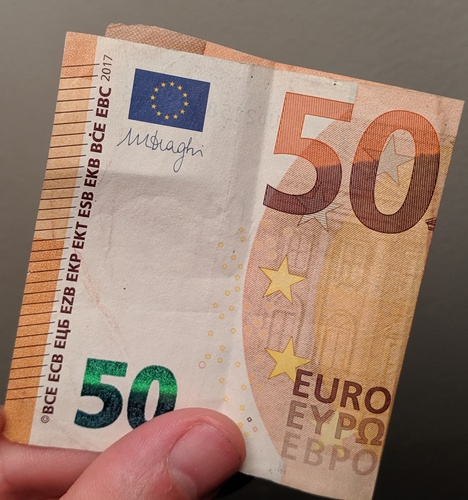

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '20.13', '0.00', '79.87', '0.00']
{'50': (4.878979, 0.20129684, '20.13'), 'euro': (6.257168, 0.7986871, '79.87')}
['50', 'euro']
   ---> or:  {}


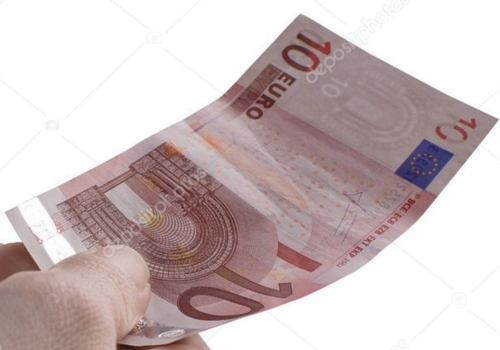

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '43.45', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '56.55', '0.00']
{'10': (8.64153, 0.43453878, '43.45'), 'euro': (8.904886, 0.56546104, '56.55')}
['10', 'euro']
   ---> or:  {}


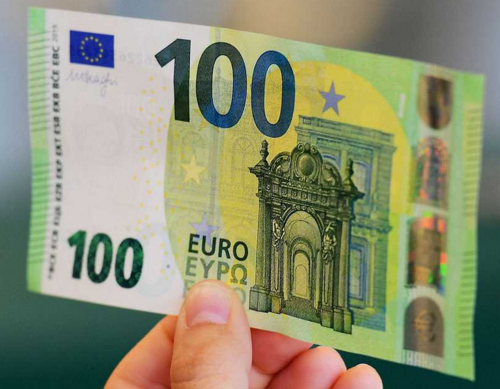

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '1.61', '0.00', '0.00', '0.00', '0.00', '0.00', '98.39', '0.00']
{'100': (5.1745114, 0.016070625, '1.61'), 'euro': (9.289072, 0.9839289, '98.39')}
['100', 'euro']
   ---> or:  {}


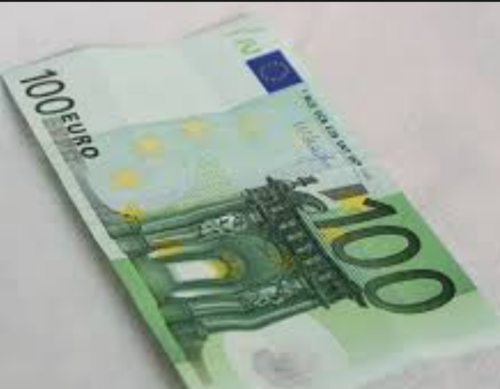

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '3.50', '0.00', '0.00', '0.00', '0.00', '0.00', '96.50', '0.00']
{'100': (7.70134, 0.034980338, '3.50'), 'euro': (11.0187025, 0.96501964, '96.50')}
['100', 'euro']
   ---> or:  {}


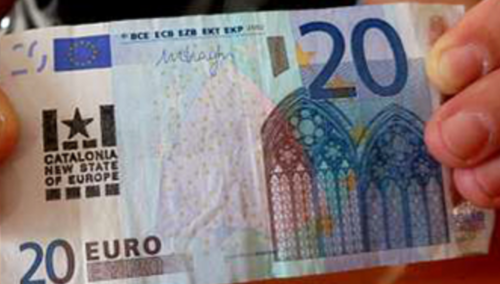

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '0.00', '58.41', '0.00', '0.00', '0.00', '0.00', '41.59', '0.00']
{'20': (6.1703978, 0.58410114, '58.41'), 'euro': (5.8307223, 0.41588083, '41.59')}
['20', 'euro']
   ---> or:  {}


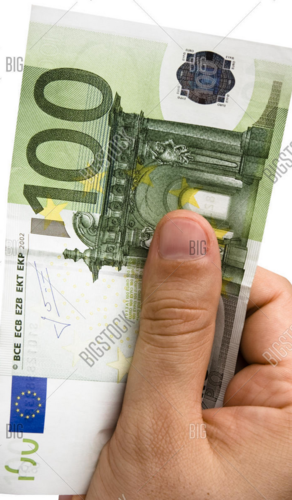

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '47.93', '0.00', '0.00', '0.00', '0.00', '0.00', '52.07', '0.00']
{'100': (7.404307, 0.47934735, '47.93'), 'euro': (7.4869623, 0.5206515, '52.07')}
['100', 'euro']
   ---> or:  {}


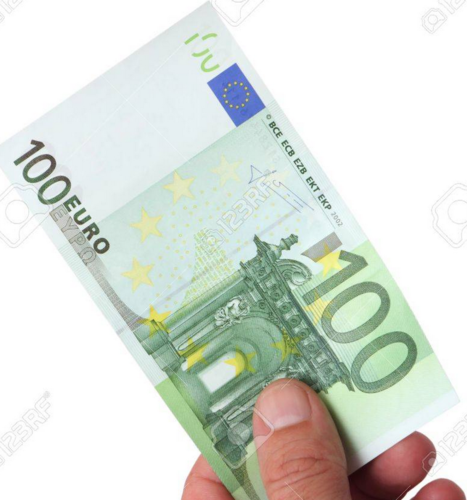

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '40.84', '0.00', '0.00', '0.00', '0.00', '0.00', '59.16', '0.00']
{'100': (8.322638, 0.40835643, '40.84'), 'euro': (8.693401, 0.59164345, '59.16')}
['100', 'euro']
   ---> or:  {}


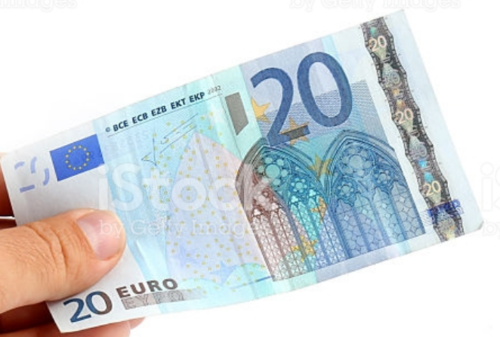

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '0.00', '60.09', '0.00', '0.00', '0.00', '0.00', '39.91', '0.00']
{'20': (9.334409, 0.6009232, '60.09'), 'euro': (8.925096, 0.3990768, '39.91')}
['20', 'euro']
   ---> or:  {}


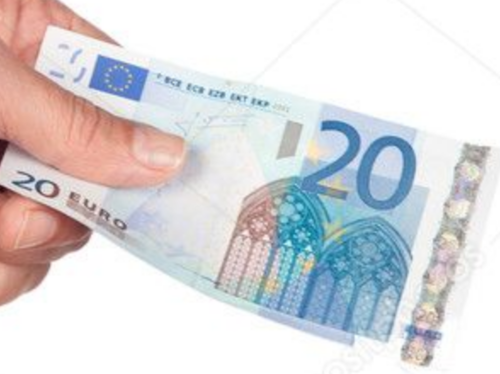

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '0.00', '49.42', '0.00', '0.00', '0.00', '0.00', '50.58', '0.00']
{'20': (9.075262, 0.49420735, '49.42'), 'euro': (9.0984335, 0.50579256, '50.58')}
['20', 'euro']
   ---> or:  {}


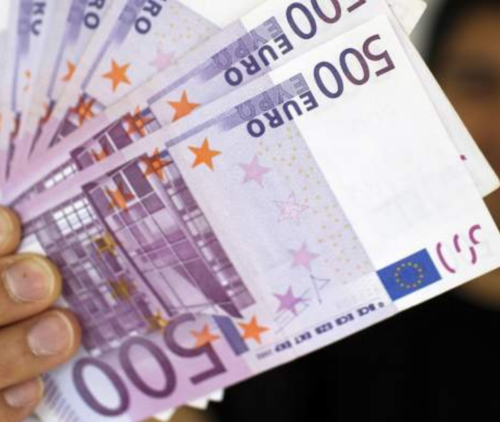

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']
[-8.247621, -5.0105467, -8.291611, -7.530572, -10.818773, -6.8693266, 5.947507, -9.181368, -12.370056, 13.03781]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '61.80', '38.19', '0.00']
{'500': (7.7606716, 0.6180484, '61.80'), 'euro': (7.279393, 0.38194948, '38.19')}
['500', 'euro']
   ---> or:  {}


In [191]:
from random import shuffle

path_imgs = Path("./imgs/euro")
#path_imgs = Path("./docs/assets")
src = (ImageList.from_folder(path_imgs,recurse=True))
shuffle(src.items)

for i in np.arange(10):
    img=src.items[i]
    display(Image(img))
    results=predict(src.items[i])
    print(classes)
    print(results['output'])
    print(results['predictions'])
    print(results['probabilities'])
    print(results['summary'])
    print("   ---> or: ",results['others'])